In [172]:
import datetime as dt
import pandas as pd
import numpy as np
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt


NETWORK_STORAGE = "Network storage"
LOCAL_STORAGE = "local storage"

NAME_DIRICTORY_FOR_DATA_SOURCE = "Data source"

PATH_LOCAL_STORAGE_VMK = os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, "ВМК\\")
PATH_LOCAL_STORAGE_VMK2 = os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, "ВМК2\\")
PATH_LOCAL_STORAGE_ROSTELECOM = os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, "Ростелеком\\") 

PATH_REPORTS = "./Reports"

PATH_NETWORK_STORAGE_VMK = "Z:/ОСЦ/PUBLIC/Недозвоны/ВМК/"
PATH_NETWORK_STORAGE_VMK2 = "Z:/ОСЦ/PUBLIC/Недозвоны/ВМК2/"
PATH_NETWORK_STORAGE_ROSTELECOM = "Z:/ОСЦ/PUBLIC/Недозвоны/Ростелеком/"
PATH_DATA_SOURCE = os.path.join("./", NAME_DIRICTORY_FOR_DATA_SOURCE)

holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5)]
   

# Создание структуры проекта
def create_folder(path):
        if not os.access(path, os.F_OK):
            os.mkdir(path)

            
def create_strucutre_folders():
    create_folder(path=PATH_REPORTS)
    create_folder(path=PATH_DATA_SOURCE)
  

def preprocess_dataframe(dataframe):
    dataframe['Время звонка']=dataframe['Время звонка'].astype('str')
    dataframe['Время ожидания']=pd.to_timedelta(dataframe['Время ожидания'].astype('str'))
    dataframe['Время разговора']=pd.to_timedelta(dataframe['Время разговора'].astype('str'))
    
    dataframe=dataframe.groupby((dataframe[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                  'Время ожидания': 'first', 'Время разговора': 'first',
                  'Группа': 'first', 'Оператор': 'first'})
    
    dataframe['Время звонка']=dataframe['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    dataframe['Дата звонка']=dataframe['Время звонка'].dt.date
    dataframe['День недели']=dataframe['Время звонка'].apply(lambda x: x.weekday())
    dataframe['Час звонка']=dataframe['Время звонка'].dt.hour
    dataframe['Время звонка']=dataframe['Время звонка'].dt.time

    dataframe['Время ожидания']=dataframe['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    dataframe['Время разговора']=dataframe['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    dataframe['Оператор']= dataframe['Оператор'].replace({np.nan:None})
    dataframe['Отчетная дата'] = dataframe['Дата звонка'] + dt.timedelta(days=1) 
    return dataframe


def preprocess_dataframe_rostelecom(df):
    df = df.rename(columns={'Первый ответивший': 'Оператор'})
    df['Группа']=df['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
    df['Группа']=df['Группа'].fillna('Не определена')
    df['Оператор']=df['Оператор'].replace({' ':'Не определен'})

    df = df.drop(df[(df['Группа'] =='Не определена') & (df['Статус'] =='пропущенный')].index)
    df = df.drop(df[(df['Длительность'] < 120) & (df['Статус'] =='пропущенный')].index)

    df['Номер вызывающего']=df['Номер вызывающего'].str.replace(' ', '')
    df['Номер вызываемого']=df['Номер вызываемого'].str.replace(' ', '')
    hospitals=pd.read_excel(os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, 'Переадресация телефонов.xlsx'))
    df=df.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('клиническая поликлиника','КП')
    return df


def table_waiting_time(total):
    total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
    total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
    total['Время ожидания звонка']=total['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка', 'Номер телефона', 'Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
#     print(table)
    return table


def table_waiting_time2(total_all_days):
    total_all_days['Ждали']=total_all_days['Время ожидания'].apply(lambda x: x*60)
    total_all_days['Ждали']= total_all_days.apply(lambda row: row['Ждали'], axis=1)
    total_all_days['Время ожидания звонка']=total_all_days['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total_all_days.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    return table


# -
def calculate_statistics(dataframe, title):
    reporting_date = dataframe['Дата звонка'].values[0]
    
    day = dataframe[(dataframe['Час звонка'] >=0 ) & (dataframe['Час звонка']  < 24)]
    night = dataframe[(dataframe['Час звонка'] < 0) | (dataframe['Час звонка'] >= 24)]
    oper_df=dataframe[(dataframe['Оператор'].notna()) & (dataframe['Оператор']!='--')]

    # Рассчитываем количество операторов в рабочее время (c 8:00 по 20:00)
    work_day_df = oper_df[(oper_df['Час звонка']>=0) & (oper_df['Час звонка'] < 24)]
    all_oper_day = len(work_day_df['Оператор'].unique())
    oper_day=len(work_day_df[work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())

    # Рассчитываем количество операторов в НЕ рабочее время
    not_work_day_df = oper_df[(oper_df['Час звонка'] < 0) | (oper_df['Час звонка'] >= 24)]
    all_oper_night = len(not_work_day_df['Оператор'].unique())
    oper_night=len(not_work_day_df[not_work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())
    all_oper = len(oper_df['Оператор'].unique())


    # Рассчитываем количество званков всего
    all_calls = dataframe.shape[0]
    # Рассчитываем количество званков ночью
    all_night_calls = night.shape[0]
    # Рассчитываем количество званков днём
    all_work_day_calls = day.shape[0]


    # Рассчитываем количество пропущенных всего званков
    all_missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков днём
    day_missed_calls = day[day["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков ночью
    night_missed_calls = night[night["Статус звонка"]=='Не дождался'].shape[0]


    # Рассчитываем среднее время разговора за сутки
    mean_talk=np.round(dataframe['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за день
    day_mean_talk=np.round(day['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за ночь
    night_mean_talk = np.round(night['Время разговора'].mean(),1)


    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    # За сутки
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]
    # За день
    max_wait_day_df = day[day['Время ожидания']==day['Время ожидания'].max()]
    max_wait_day = np.round(day['Время ожидания'].max(),1)
    time_with_max_wait_day = max_wait_day_df['Время звонка'].values[0]
    # За ночь
    max_wait_night_df = night[night['Время ожидания'] == night['Время ожидания'].max()]
    max_wait_night = np.round(night['Время ожидания'].max(),1)    
    time_with_max_wait_night =  0 if max_wait_night_df.empty else max_wait_night_df['Время звонка'].values[0]    
    
    
    # Рассчитываем у какого оператора было максимальнок время ожидание и в какой он группе
    # За сутки
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]
    # За день
    group_with_max_wait_day = max_wait_day_df['Группа'].values[0]
    oper__with_max_wait_day = max_wait_day_df['Оператор'].values[0]
    # За ночь
    group_with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Группа'].values[0]
    oper__with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Оператор'].values[0]
    
    
    # Рассчитываем среднее время ожидание
    all_wait = dataframe['Время ожидания']
    day_wait = day['Время ожидания']
    night_wait = night['Время ожидания']
    # За сутки
    mean_wait = np.round(all_wait.mean(),5)
    # За день
    mean_wait_day = np.round(day_wait.mean(),5)
    # За ночь
    mean_wait_night = np.round(night_wait.mean(),5)

    # Рассчитываем ожидание более 3 минут
    # За сутки
    more_3_min_df = dataframe[all_wait >= 3].shape[0]
    more_3_min = np.round(more_3_min_df * 100 / all_calls, 0)
    # За день
    more_3_min_day_df = day_wait[day_wait >= 3].shape[0]
    more_3_min_day = np.round(more_3_min_day_df * 100 / all_calls, 0)
    # За ночь
    more_3_min_night_df = night_wait[night_wait >= 3].shape[0]
    more_3_min_night = np.round(more_3_min_df * 100 / all_calls, 0)

    # За сутки
    print(f'{title}\nза {reporting_date}\n')
    print('Информация за сутки: \n')
    print(f'Число операторов всего: {all_oper},\nВсего звонков {all_calls}, неотвеченных вызовов: {all_missed_calls}')
    print(f'Среднее время разговора за сутки (мин): {mean_talk}')
    print(f'Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait})')
    print(f'Среднее время ожидания за сутки(мин): {mean_wait}')
    print(f'Ожидание более 3 минут за сутки (%): {more_3_min}\n')

    # За день
    print('\nИнформация за рабочий день (с 8:00 до 20:00): \n')
    print(f'Число операторов днем {all_oper_day}, из них {oper_day} отвечали на звонки')
    print(f'Днем позвонили {all_work_day_calls} раз, из них неотвеченных вызовов: {day_missed_calls}')
    print(f'Среднее время разговора денём (мин): {day_mean_talk}')
    print(f'Максимальное время ожидания днём (мин): {max_wait_day} (Оператор: {oper__with_max_wait_day}, Группа: {group_with_max_wait_day}, Время звонка: {time_with_max_wait_day})')
    print(f'Среднее время ожидания днём (мин): {mean_wait_day}')
    print(f'Ожидание более 3 минут днём (%): {more_3_min_day}\n')

    # За ночь
    print('\nИнформация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): \n')
    print(f'Число операторов ночью {all_oper_night}, из них {oper_night} отвечали на звонки')
    print(f'Ночью позвонили {all_night_calls} раз, из них неотвеченных вызовов: {night_missed_calls}')      
    print(f'Среднее время разговора ночью (мин): {night_mean_talk}')
    print(f'Максимальное время ожидания ночью (мин): {max_wait_night} (Оператор: {oper__with_max_wait_night}, Группа: {group_with_max_wait_night}, Время звонка: {time_with_max_wait_night})')    
    print(f'Среднее время ожидания ночью (мин): {mean_wait_night}')
    print(f'Ожидание более 3 минут ночью (%): {more_3_min_night}')


def create_df(names):
    cont = []
    for i in range(len(names)):
        if '~$' in names[i]:
            continue
        df = pd.read_excel(names[i], engine='openpyxl')
        df = preprocess_dataframe(df)
        
        # Костыль, устранение пустых значений у данных полей. Значения заменяются на медианные
        df['Время разговора'] = df['Время разговора'].apply(lambda x: x if str(x) != "nan" else  round(df['Время разговора'].median(), 6))
        df['Время ожидания'] = df['Время ожидания'].apply(lambda x: x if str(x) != "nan" else  round(df['Время ожидания'].median(), 6))

        cont.append(df)
    return pd.concat(cont)


def load_one_table(path_storage, day_statictics_calculation, start_hour_job, end_hour_job, is_VMK=False):
    path_load_file = os.path.join(path_storage, str(day_statictics_calculation) + ".xlsx")
    
    if os.access(path_load_file, os.F_OK):
        if is_VMK:
            incorrect_rows_list = list()

            df = pd.read_excel(path_load_file)
            df = preprocess_dataframe(df)
            
            df = df[(df['Час звонка'] >= start_hour_job) & (df['Час звонка'] < end_hour_job)]
            df['Группа'] = df['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})
            
            # Костыль, устранение пустых значений у данных полей. Значения заменяются на медианные
            df['Время разговора'] = df['Время разговора'].apply(lambda x: x if str(x) != "nan" else  round(df['Время разговора'].median(), 6))
            df['Время ожидания'] = df['Время ожидания'].apply(lambda x: x if str(x) != "nan" else  round(df['Время ожидания'].median(), 6))

            return df
        else:   
            date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', path_load_file).group()
            df_RT = pd.read_excel(path_load_file, dtype={'Номер вызывающего': str})
            if (dt.datetime.strptime(date, "%Y-%m-%d") < dt.datetime(2021,4,22)):
                df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
                df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
            else:
                df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
                df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
            df_RT=df_RT[df_RT['Длительность'] > 9]

            df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
            df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
            df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
            df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
            df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
            df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
            df_RT['Время вызова']=df_RT['Время вызова'].dt.time 
            
            df_RT = preprocess_dataframe_rostelecom(df_RT)
            df_RT = df_RT[(df_RT['Час звонка'] >= start_hour_job) & (df_RT['Час звонка'] < end_hour_job)] 
            return df_RT 
    else:
        print(f"Файл {str(day_statictics_calculation) + '.xlsx'} НЕ НАЙДЕН в директории: {path_storage}")
        return None
    
    
# РОСТЕЛЕКОМ
# Определение зон
def give_missed_calls_zone(percentage):
    zone = ''
    if (percentage >= 15):
        zone = 'красная'
    elif ( 5 < percentage < 15):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


def give_mean_wait_zone(time_wait):
    zone = ''
    if (time_wait > 10):
        zone = 'красная'
    elif ( 2 < time_wait <= 10):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


# Cчитаем отчёт для ЕА
def report_for_EA(df_VMK, df_RT):
    # дата отчёта
    report_data = df_VMK['Дата звонка'].values[0].strftime("%d.%m.%Y")
    # всего звонков
    all_calls = df_RT[df_RT['Номер вызываемого']=='78442325552'].shape[0]
    # количество неотвеченных
    missed_calls_count = df_RT[(df_RT['Статус']=='пропущенный') & (df_RT['Номер вызываемого']=='78442325552')].shape[0]   
    # Рассчитываем процент недозвонов    
    percentage_missed = np.round(missed_calls_count/all_calls * 100, 2)
    missed_calls_zone = give_missed_calls_zone(percentage_missed)
    # Рассчитываем среднее время ожидания
    mean_wait = np.round(df_VMK['Время ожидания'].mean(),3)
    mean_wait_zone = give_mean_wait_zone(mean_wait)
        
    print(f"""Информация по вызовам на "122" за {report_data}:
Всего вызовов: {all_calls}
Неотвеченных вызовов: {missed_calls_count} ( {str(percentage_missed).replace('.',',')}%, {missed_calls_zone} зона)
Среднее время ожидания: {str(mean_wait).replace('.',',')} мин. ({mean_wait_zone} зона)
""")   


# def rename_df_RT(dataframeRT):
#     dataframeRT = dataframeRT.rename(columns={'Первый ответивший': 'Оператор'})
#     dataframeRT['Группа']=dataframeRT['Группа'].fillna('Не определена')
#     dataframeRT['Оператор']=dataframeRT['Оператор'].replace({' ':'Не определен'})

#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Группа'] =='Не определена') & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Длительность'] < 120) & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT['Номер вызывающего']=dataframeRT['Номер вызывающего'].str.replace(' ', '')
#     dataframeRT['Номер вызываемого']=dataframeRT['Номер вызываемого'].str.replace(' ', '')


#     hospitals=pd.read_excel(os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, 'Переадресация телефонов.xlsx'))
#     dataframeRT=dataframeRT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')
#     return dataframeRT
# total_all_days_RT = rename_df_RT(total_all_days_RT)
# #total_all_days_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == '2022-02-10'] 
# total_all_days_RT
# # x = total_all_days_RT['Дата вызова'].values[0]
# # print(x)
# # print(type(x))
# # total_all_days_RT


def calculate_statistics_RT(dataframe):
    all_calls_count=dataframe.shape[0]
    all_calls_5552_count=dataframe[dataframe['Номер вызываемого']=='78442325552'].shape[0]
    all_calls_5554_count=dataframe[dataframe['Номер вызываемого']=='78442325554'].shape[0]
    missed_calls=dataframe[dataframe['Статус']=='пропущенный']
    missed_calls_count=missed_calls.shape[0]
    missed_calls_5552_count=missed_calls[missed_calls['Номер вызываемого']=='78442325552'].shape[0]
    missed_calls_5554_count=missed_calls[missed_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    hospital_calls=dataframe[dataframe['Наименование учреждения'].isnull()==False]
    hospital_calls_count=hospital_calls.shape[0]
    hospital_calls_count_5552=hospital_calls[hospital_calls['Номер вызываемого']=='78442325552'].shape[0]
    hospital_calls_count_5554=hospital_calls[hospital_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    print('По выгрузке Ростелекома: неотвеченных вызовов - {0} %'.format(np.round(missed_calls_5552_count / all_calls_5552_count*100,2)))
    print('Всего вызовов – {0}, неотвеченных – {1} (отфильтровано менее 120 сек, а также по группе "Не определена").'.format(all_calls_5552_count, missed_calls_5552_count))


def calculate_statistics_WMK(dataframe, report_one_day=True):      
    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]    
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]    
    report_data = dataframe['Дата звонка'].values[0].strftime("%d.%m.%Y")
    report_data_time = dt.datetime.now().strftime("%H:%M")
    
    if report_one_day:
        print(f"""
Информация по вызовам по состоянию на {report_data_time} за {report_data}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
        """)
    else:
        print(f"""
Информация по вызовам по состоянию с 8:00 {dataframe['Дата звонка'].min().strftime('%d.%m.%Y')} по 8:00 {dataframe['Дата звонка'].max().strftime('%d.%m.%Y')}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
        """)    
        

def calculate_values_for_report_vmk(df):
    report_mob_vmk_values = {'total_number_calls': None, 'SL_for_10_minutes': None, 'max_time_wait_call': None, 'mean_time_wait_call': None,
                             'mean_time_talked_on_phone': None, 'list_users_work_for_day': None, 'number_users_work_for_day': None, 
                            'description_keys': {'total_number_calls': 'Общее количество звонков' , 'SL_for_10_minutes': 'SL за 10 сек., %',
                            'max_time_wait_call': 'Максимальное время ожидания ответа от оператора', 'mean_time_wait_call': 'Среднее время ожидания ответа от оператора',
                            'mean_time_talked_on_phone': 'Среднее время разговора', 'list_users_work_for_day': 'Cписок пользователей, работающих в течение дня',
                            'number_users_work_for_day': 'Количество пользователей, работающих в течение дня'}}
    
    report_mob_vmk_values['total_number_calls'] = df.shape[0]
    report_mob_vmk_values['SL_for_10_minutes'] =  round(df[df['Время ожидания']  < 0.17].shape[0] / report_mob_vmk_values.get('total_number_calls') * 100 
                                                      if report_mob_vmk_values.get('total_number_calls') != 0 else 0.00 , 2)
    
    report_mob_vmk_values['max_time_wait_call'] = round(df['Время ожидания'].max(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
    report_mob_vmk_values['mean_time_wait_call'] = round(df['Время ожидания'].mean(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
    report_mob_vmk_values['mean_time_talked_on_phone'] = round(df['Время разговора'].mean(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
    
    tmp_list_users = [user for user in df.Оператор.unique() if 'user' in user]
    tmp_list_users.sort()
    report_mob_vmk_values['list_users_work_for_day'] = ", ".join(tmp_list_users)
    report_mob_vmk_values['number_users_work_for_day'] = len(tmp_list_users)
    return report_mob_vmk_values

    
def print_calculate_statistics_WMK_mob(dict_values):
    print(f"1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: {dict_values.get('total_number_calls')}")
    print(f"2. SL за 10 сек., %: {dict_values.get('SL_for_10_minutes')}")
    print(f"3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: {dict_values.get('max_time_wait_call')}")
    print(f"4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: {dict_values.get('mean_time_wait_call')}")
    print(f"5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: {dict_values.get('mean_time_talked_on_phone')}")


create_strucutre_folders()

# Настройка параметров для ВМК, ВМК2 и Ростелекома

In [173]:
# Выбираем день для расчета статистики по ВМК, ВМК2 и Ростелекому
DAY_STATICTICS_CALCULATION = dt.date(2022,10,12)

# Задаем время работы в колл-центре
START_HOUR_JOB = 0
END_HOUR_JOB = 24

# Дата для отчета с 8:00 текущего дня и до 8:00 следущего дня
# Обязательно указать дату дня (первого) с 8:00 до 24:00
DAY_STATICTICS_CALCULATION_FROM_8_to_8 = dt.date(2022,10,12)

# Расположение хранилища файлов
# Выберете од их вариантов хранилища файлов, остальные закомментируйте 
# type_storage = LOCAL_STORAGE
type_storage = NETWORK_STORAGE


# Дополнительные настройки 
# При необходимости можно задать разные отчетные даты для  ВМК, ВМК2 и Ростелекома
DAY_STATICTICS_CALCULATION_VMK1 =  DAY_STATICTICS_CALCULATION
DAY_STATICTICS_CALCULATION_VMK2 =  DAY_STATICTICS_CALCULATION
DAY_STATICTICS_CALCULATION_ROSTELECOM =  DAY_STATICTICS_CALCULATION

### Формирование DataFrame за один день для ВМК, ВМК2 и Ростелеком

In [174]:
# Определение путей к хранилищам файлов
PATH_STORAGE_VMK = PATH_LOCAL_STORAGE_VMK  if type_storage == "local storage" else PATH_NETWORK_STORAGE_VMK
PATH_STORAGE_VMK2 = PATH_LOCAL_STORAGE_VMK2  if type_storage == "local storage" else PATH_NETWORK_STORAGE_VMK2
PATH_STORAGE_ROSTELECOM = PATH_LOCAL_STORAGE_ROSTELECOM if type_storage == "local storage" else PATH_NETWORK_STORAGE_ROSTELECOM

# Создаём датафрейм ВМК для первого домена 
# df_specific_day = total_all_days[total_all_days['Дата звонка']== DAY_STATICTICS_CALCULATION_VMK1].copy()
df_specific_day = load_one_table(path_storage=PATH_STORAGE_VMK, day_statictics_calculation=(DAY_STATICTICS_CALCULATION_VMK1 + dt.timedelta(1)), 
                                  start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB, is_VMK=True)
reporting_date = df_specific_day['Дата звонка'].values[0]

# Создаём датафрейм ВМК2 для второго домена
# df_specific_day2 = total_all_days2[total_all_days2['Дата звонка'] == DAY_STATICTICS_CALCULATION_VMK1]
df_specific_day2 = load_one_table(path_storage=PATH_STORAGE_VMK2, day_statictics_calculation=(DAY_STATICTICS_CALCULATION_VMK2 + dt.timedelta(1)), 
                                  start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB, is_VMK=True)
reporting_date2 = df_specific_day2['Дата звонка'].values[0]

# Создаём датафрейм для первого домена Ростелеком за определенную дату
# df_specific_day_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == dayRT]
df_specific_day_RT =  load_one_table(path_storage=PATH_STORAGE_ROSTELECOM, day_statictics_calculation=DAY_STATICTICS_CALCULATION_ROSTELECOM, 
                                  start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB)

dayRT= str(DAY_STATICTICS_CALCULATION_ROSTELECOM)

# Создаем датафрейм по мобилизации (ВМК)
df_specific_day_mob = df_specific_day[(df_specific_day["Группа"] == "Мобилизация") & (df_specific_day['Час звонка'] >= START_HOUR_JOB) & (df_specific_day['Час звонка'] < END_HOUR_JOB)].copy()


# Печать DataFrame
# df_specific_day
# df_specific_day2
# dayRT

# ВМК и ВМК2

### Считаем статистику по первому домену (ВМК)

In [175]:
calculate_statistics(df_specific_day,'Данные по первому домену')

Данные по первому домену
за 2022-10-12

Информация за сутки: 

Число операторов всего: 30,
Всего звонков 784, неотвеченных вызовов: 14
Среднее время разговора за сутки (мин): 2.3
Максимальное время ожидания за сутки (мин): 3.3 (Оператор: user66, Группа: Мобилизация, Время звонка: 19:57:15)
Среднее время ожидания за сутки(мин): 0.09666
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 30, из них 30 отвечали на звонки
Днем позвонили 784 раз, из них неотвеченных вызовов: 14
Среднее время разговора денём (мин): 2.3
Максимальное время ожидания днём (мин): 3.3 (Оператор: user66, Группа: Мобилизация, Время звонка: 19:57:15)
Среднее время ожидания днём (мин): 0.09666
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожи

### Таблица максимального времени ожидания за конктретную дату (ВМК)

In [176]:
report_max_time_wait_calls_vmk = table_waiting_time(df_specific_day).head(20)
report_max_time_wait_calls_vmk.reset_index(inplace=True, drop=True)
report_max_time_wait_calls_vmk['Дата звонка']  = report_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
report_max_time_wait_calls_vmk['Номер телефона']  = report_max_time_wait_calls_vmk['Номер телефона'].apply(lambda value: int(value))
report_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания (ВМК).xlsx"), index=False)
report_max_time_wait_calls_vmk

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,12.10.2022,79011300611,19:57:15,00:03:16,Мобилизация,user66,Не дождался
1,12.10.2022,79047746189,22:37:05,00:03:14,Мобилизация,--,Не дождался
2,12.10.2022,78446443884,20:02:36,00:02:31,Медколледж,user80,Завершён оператором
3,12.10.2022,78443580804,20:31:56,00:00:54,Мобилизация,user61,Не дождался
4,12.10.2022,79608873744,20:34:08,00:00:52,Медколледж,--,Не дождался
5,12.10.2022,79047746189,22:34:56,00:00:50,Мобилизация,--,Не дождался
6,12.10.2022,79020961879,20:32:21,00:00:44,Мобилизация,user61,Не дождался
7,12.10.2022,79044107956,20:04:01,00:00:44,Медколледж,--,Не дождался
8,12.10.2022,79047512167,08:46:47,00:00:43,Мобилизация,user109,Завершён абонентом
9,12.10.2022,79047575829,12:40:10,00:00:38,Мобилизация,user110,Завершён оператором


### Считаем статистику по второму домену (ВМК2)

In [177]:
# Считаем статистику
calculate_statistics(df_specific_day2, 'Данные по второму домену')

Данные по второму домену
за 2022-10-12

Информация за сутки: 

Число операторов всего: 21,
Всего звонков 225, неотвеченных вызовов: 11
Среднее время разговора за сутки (мин): 3.1
Максимальное время ожидания за сутки (мин): 5.1 (Оператор: user44, Группа: Вызов врача, Время звонка: 20:11:40)
Среднее время ожидания за сутки(мин): 0.24244
Ожидание более 3 минут за сутки (%): 2.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 21, из них 20 отвечали на звонки
Днем позвонили 225 раз, из них неотвеченных вызовов: 11
Среднее время разговора денём (мин): 3.1
Максимальное время ожидания днём (мин): 5.1 (Оператор: user44, Группа: Вызов врача, Время звонка: 20:11:40)
Среднее время ожидания днём (мин): 0.24244
Ожидание более 3 минут днём (%): 2.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожи

### Таблица максимального времени ожидания за конкретную дату по второму домену (ВМК2)

In [178]:
report_max_time_wait_calls_vmk2 = table_waiting_time(df_specific_day2).head(20)
report_max_time_wait_calls_vmk2.reset_index(inplace=True, drop=True)
report_max_time_wait_calls_vmk2['Дата звонка']  = report_max_time_wait_calls_vmk2['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
report_max_time_wait_calls_vmk2.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания (ВМК2).xlsx"), index=False)
report_max_time_wait_calls_vmk2

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,12.10.2022,7.909388e+10,20:11:40,00:05:08,Вызов врача,user44,Не дождался
1,12.10.2022,7.844225e+10,16:09:30,00:04:23,Вызов врача,user38,Завершён абонентом
2,12.10.2022,7.904410e+10,08:11:44,00:03:18,Диспансеризация-Ограничения,user54,Завершён оператором
3,12.10.2022,7.927504e+10,16:05:10,00:03:13,Вызов врача,user58,Не дождался
4,12.10.2022,7.961059e+10,16:03:13,00:01:15,Вызов врача,user41,Не дождался
5,12.10.2022,7.977131e+10,16:09:06,00:01:09,Вызов врача,user52,Завершён абонентом
6,12.10.2022,7.902096e+10,20:30:18,00:01:08,БЕЖЕНЫ,user51,Не дождался
7,12.10.2022,7.844280e+10,16:13:45,00:01:08,Вызов врача,user44,Завершён оператором
8,12.10.2022,7.969293e+10,18:08:28,00:00:53,Вызов врача,user52,Завершён оператором
9,12.10.2022,7.909393e+10,15:56:11,00:00:47,Диспансеризация-Ограничения,user60,Завершён оператором


### Распределение звонков по операторам на первом домене

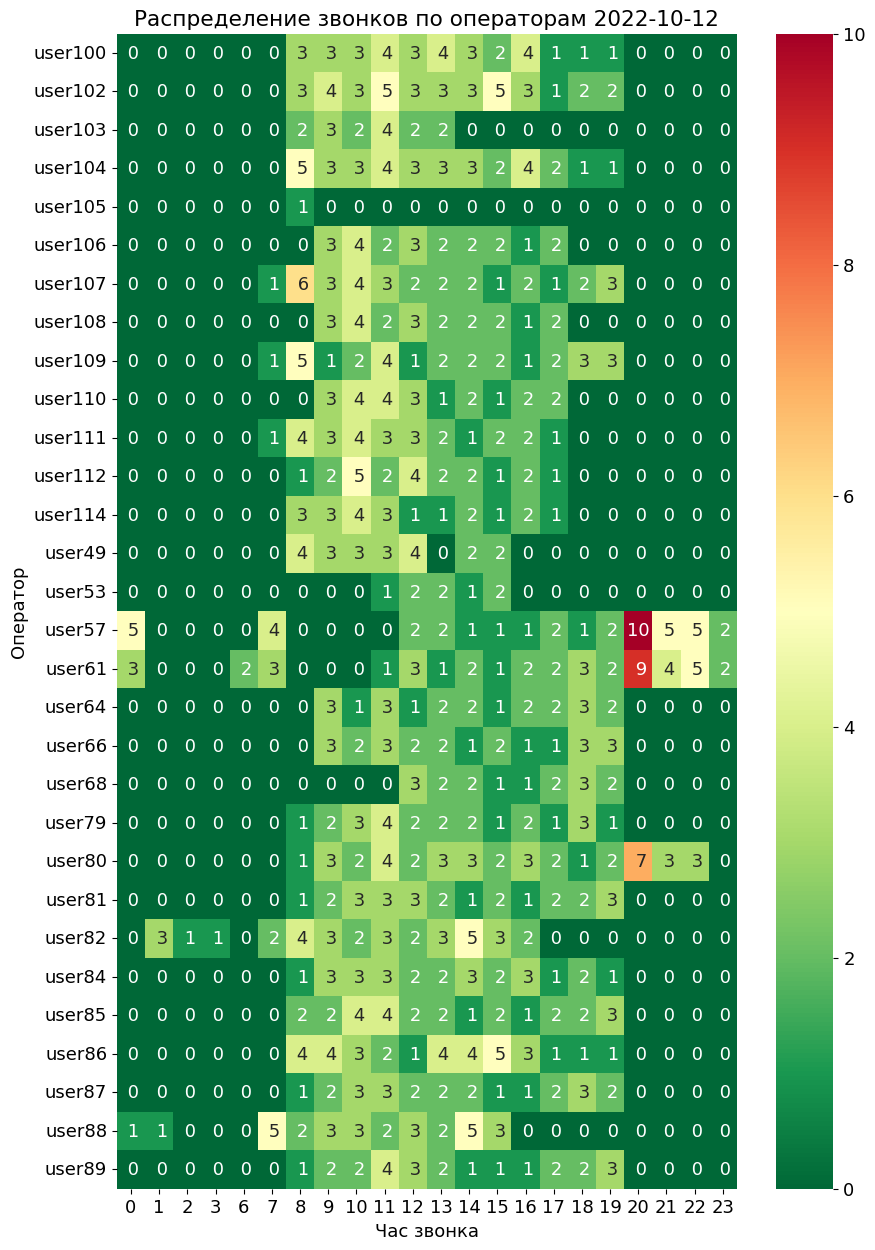

In [179]:
stress_on_oper =  df_specific_day[(df_specific_day['Оператор']!='user8') & (df_specific_day['Оператор']!='user9')& (df_specific_day['Оператор']!='Не определен') & (df_specific_day['Оператор']!='--')]

f = plt.figure(figsize=(10,15))
heatmap_plot = sns.heatmap(pd.crosstab(stress_on_oper['Оператор'], stress_on_oper['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам '+ str(reporting_date))

plt.show()

### Распределение звонков по операторам на втором домене (ВМК2)

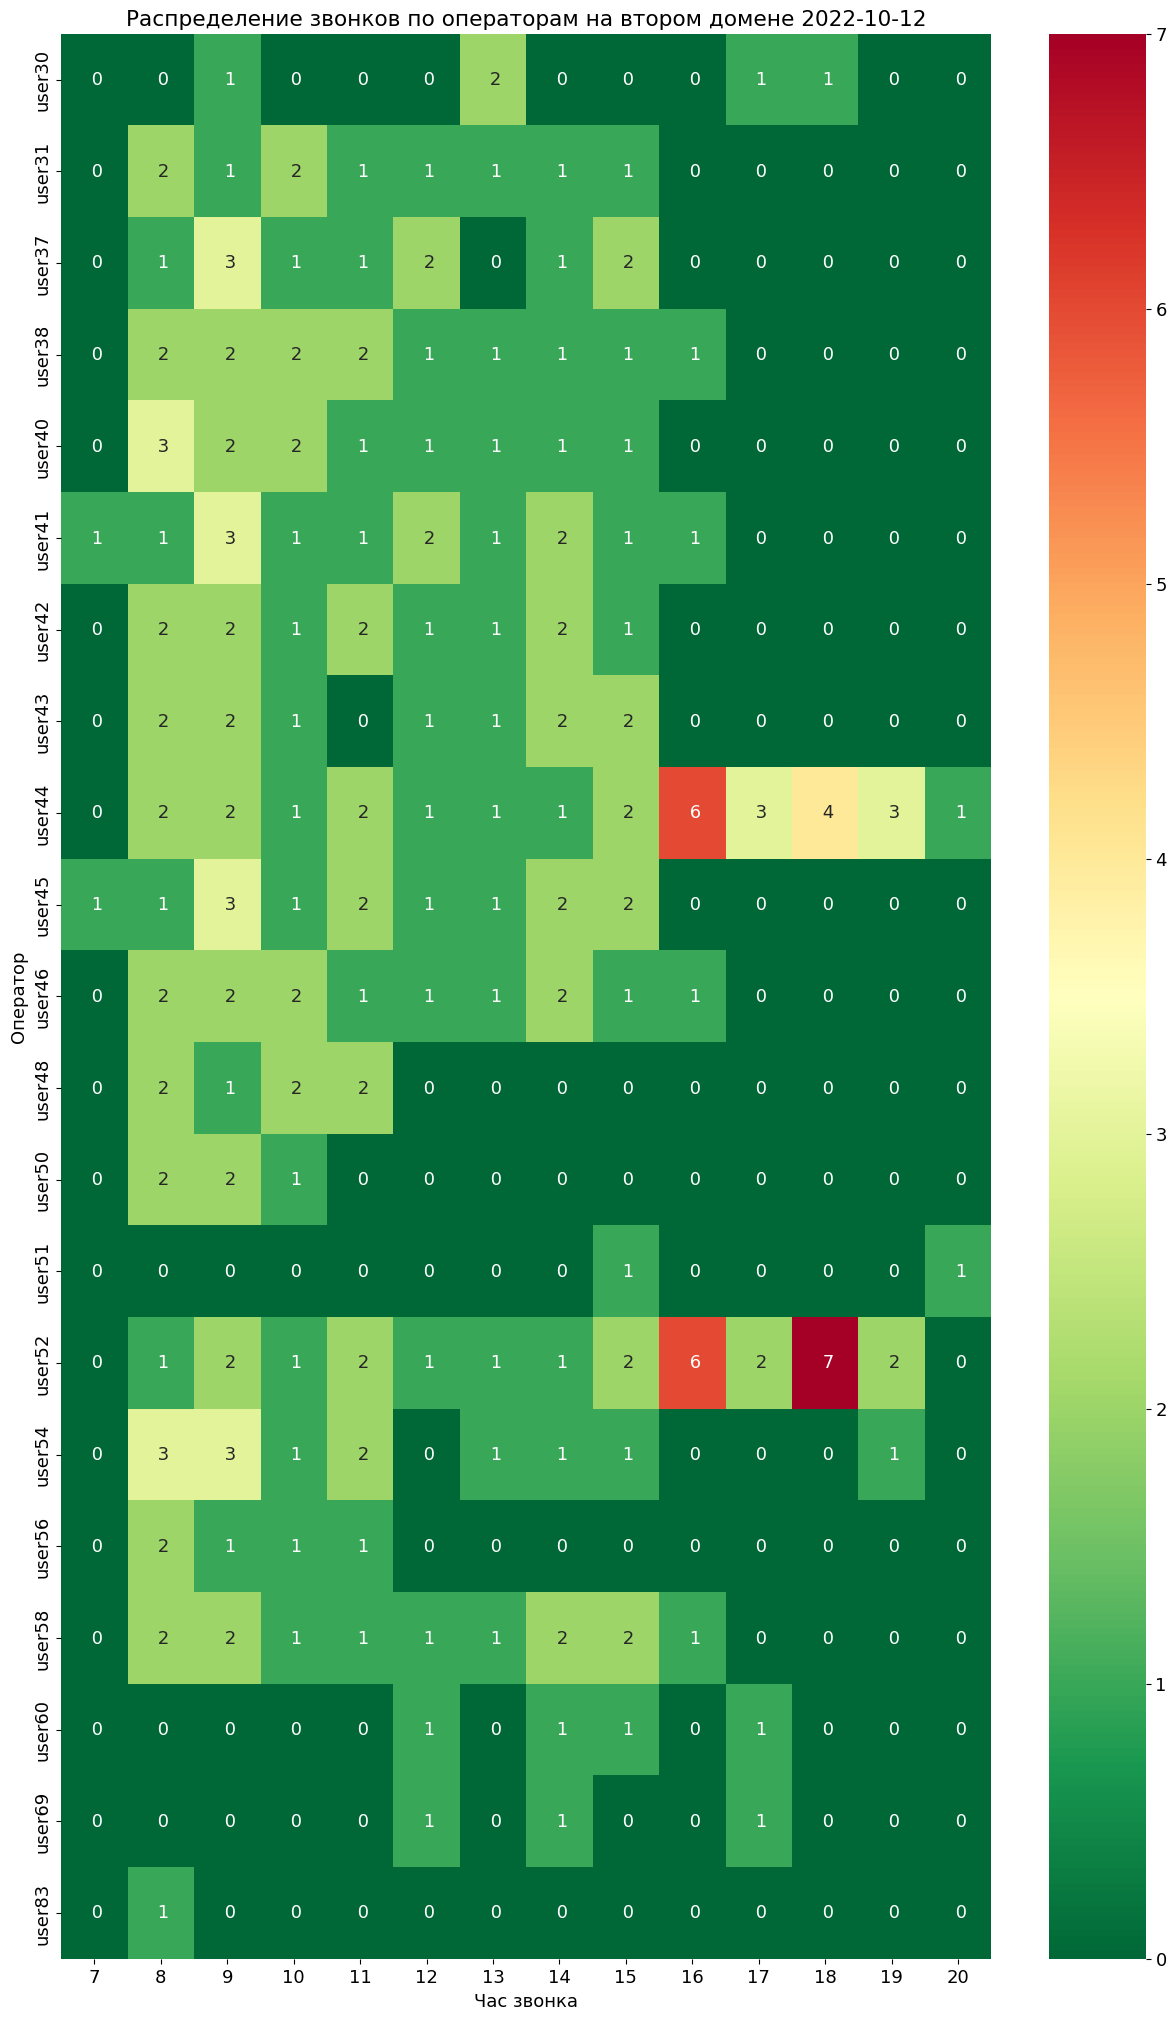

In [180]:
stress_on_oper2 =  df_specific_day2[(df_specific_day2['Оператор']!='user8') & (df_specific_day2['Оператор']!='user9') & (df_specific_day2['Оператор']!='Не определен') & (df_specific_day2['Оператор']!='--')]

f2 = plt.figure(figsize=(15,25))
heatmap_plot2 = sns.heatmap(pd.crosstab(stress_on_oper2['Оператор'], stress_on_oper2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам на втором домене '+ str(reporting_date2))

plt.show()

### Обшее количество недозвонов по часам за конкретную дату по первому домену (ВМК)

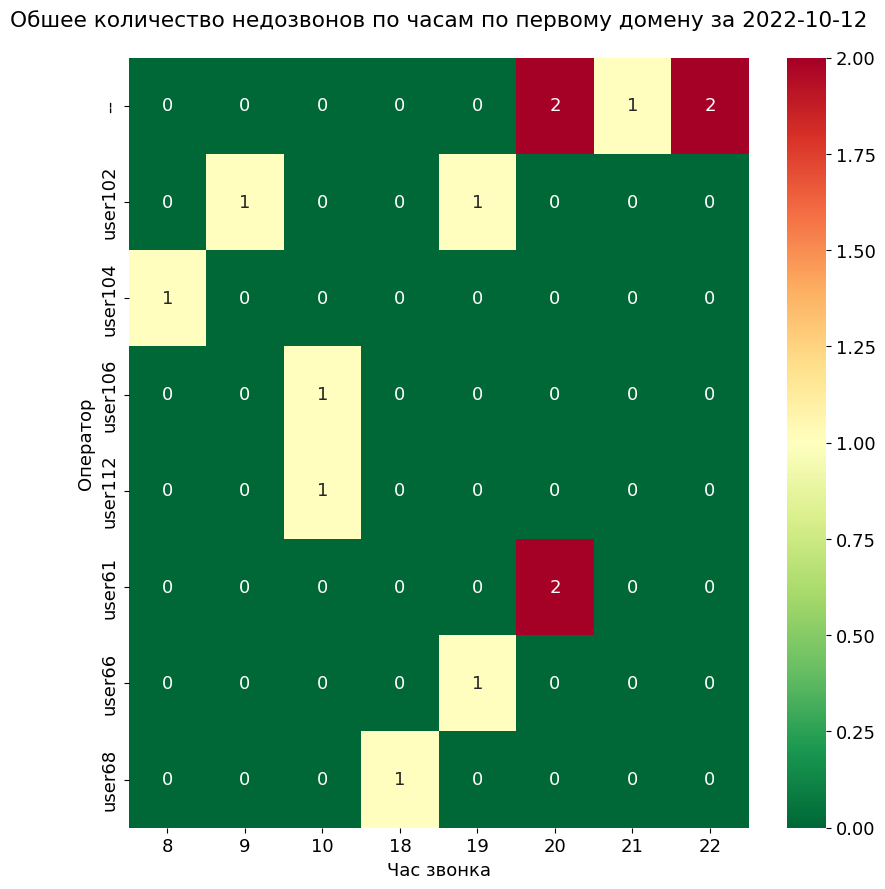

In [181]:
didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')] 
if didnot_calls.empty: 
    print("Нет пропущенных звонков на втором домене")         
else:
    didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')]

    print_didnot_calls = didnot_calls[['Время звонка', 'Номер телефона', 'Время ожидания звонка', 'Оператор']].copy()
    print_didnot_calls.to_excel(os.path.join(PATH_REPORTS, f"Обшее количество недозвонов по первому домену.xlsx"), index=False)


    f = plt.figure(figsize=(10,10))

    heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls['Оператор'], didnot_calls['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
    plt.title('Обшее количество недозвонов по часам по первому домену за '+ str(reporting_date2) + '\n')

    plt.show()

### Обшее количество недозвонов по часам за конкретную дату по второму домену (ВМК2)

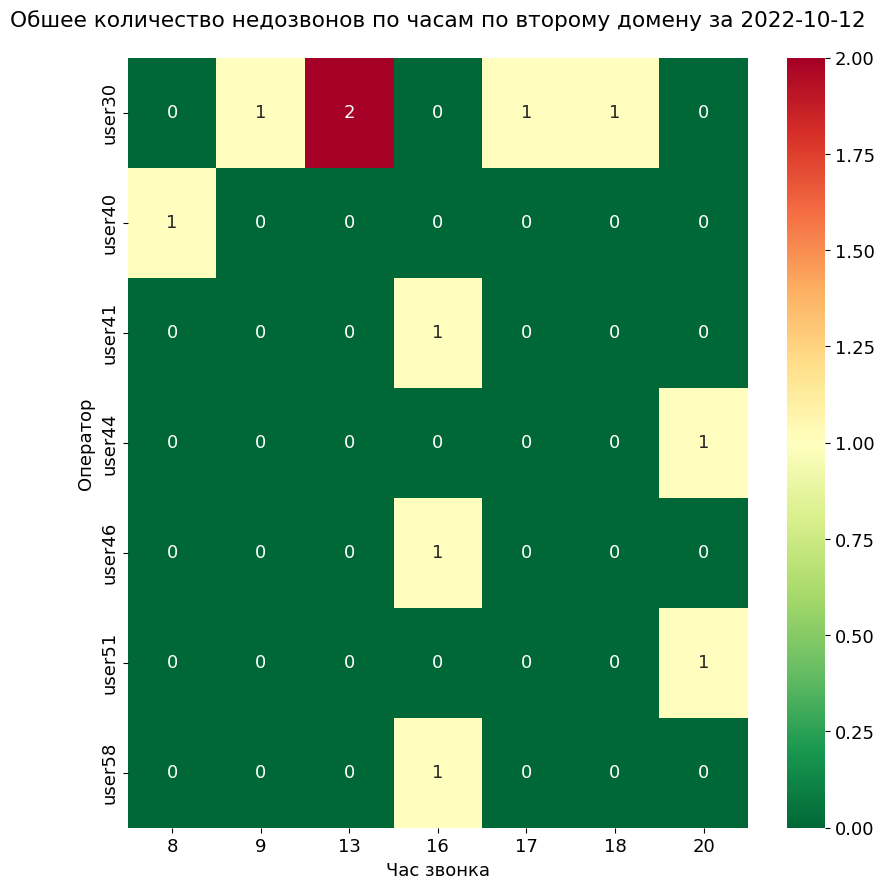

In [182]:
didnot_calls2 = df_specific_day2[(df_specific_day2['Оператор'] == '--') | (df_specific_day2['Статус звонка'] == 'Не дождался')] 
if didnot_calls2.empty: 
    print("Нет пропущенных звонков на втором домене")         
else:    
    print_didnot_calls2 = didnot_calls2[['Время звонка', 'Номер телефона', 'Группа', 'Время ожидания звонка', 'Оператор']].copy() 
    print_didnot_calls2.to_excel(os.path.join(PATH_REPORTS, f"Обшее количество недозвонов по второму домену.xlsx"), index=False) 
    
    f = plt.figure(figsize=(10,10)) 
 
    heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls2['Оператор'], didnot_calls2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1") 
    plt.title('Обшее количество недозвонов по часам по второму домену за '+ str(reporting_date2) + '\n') 
 
    plt.show()

### Распределение звонков по операторам за конкретную дату по первому домену (ВМК)

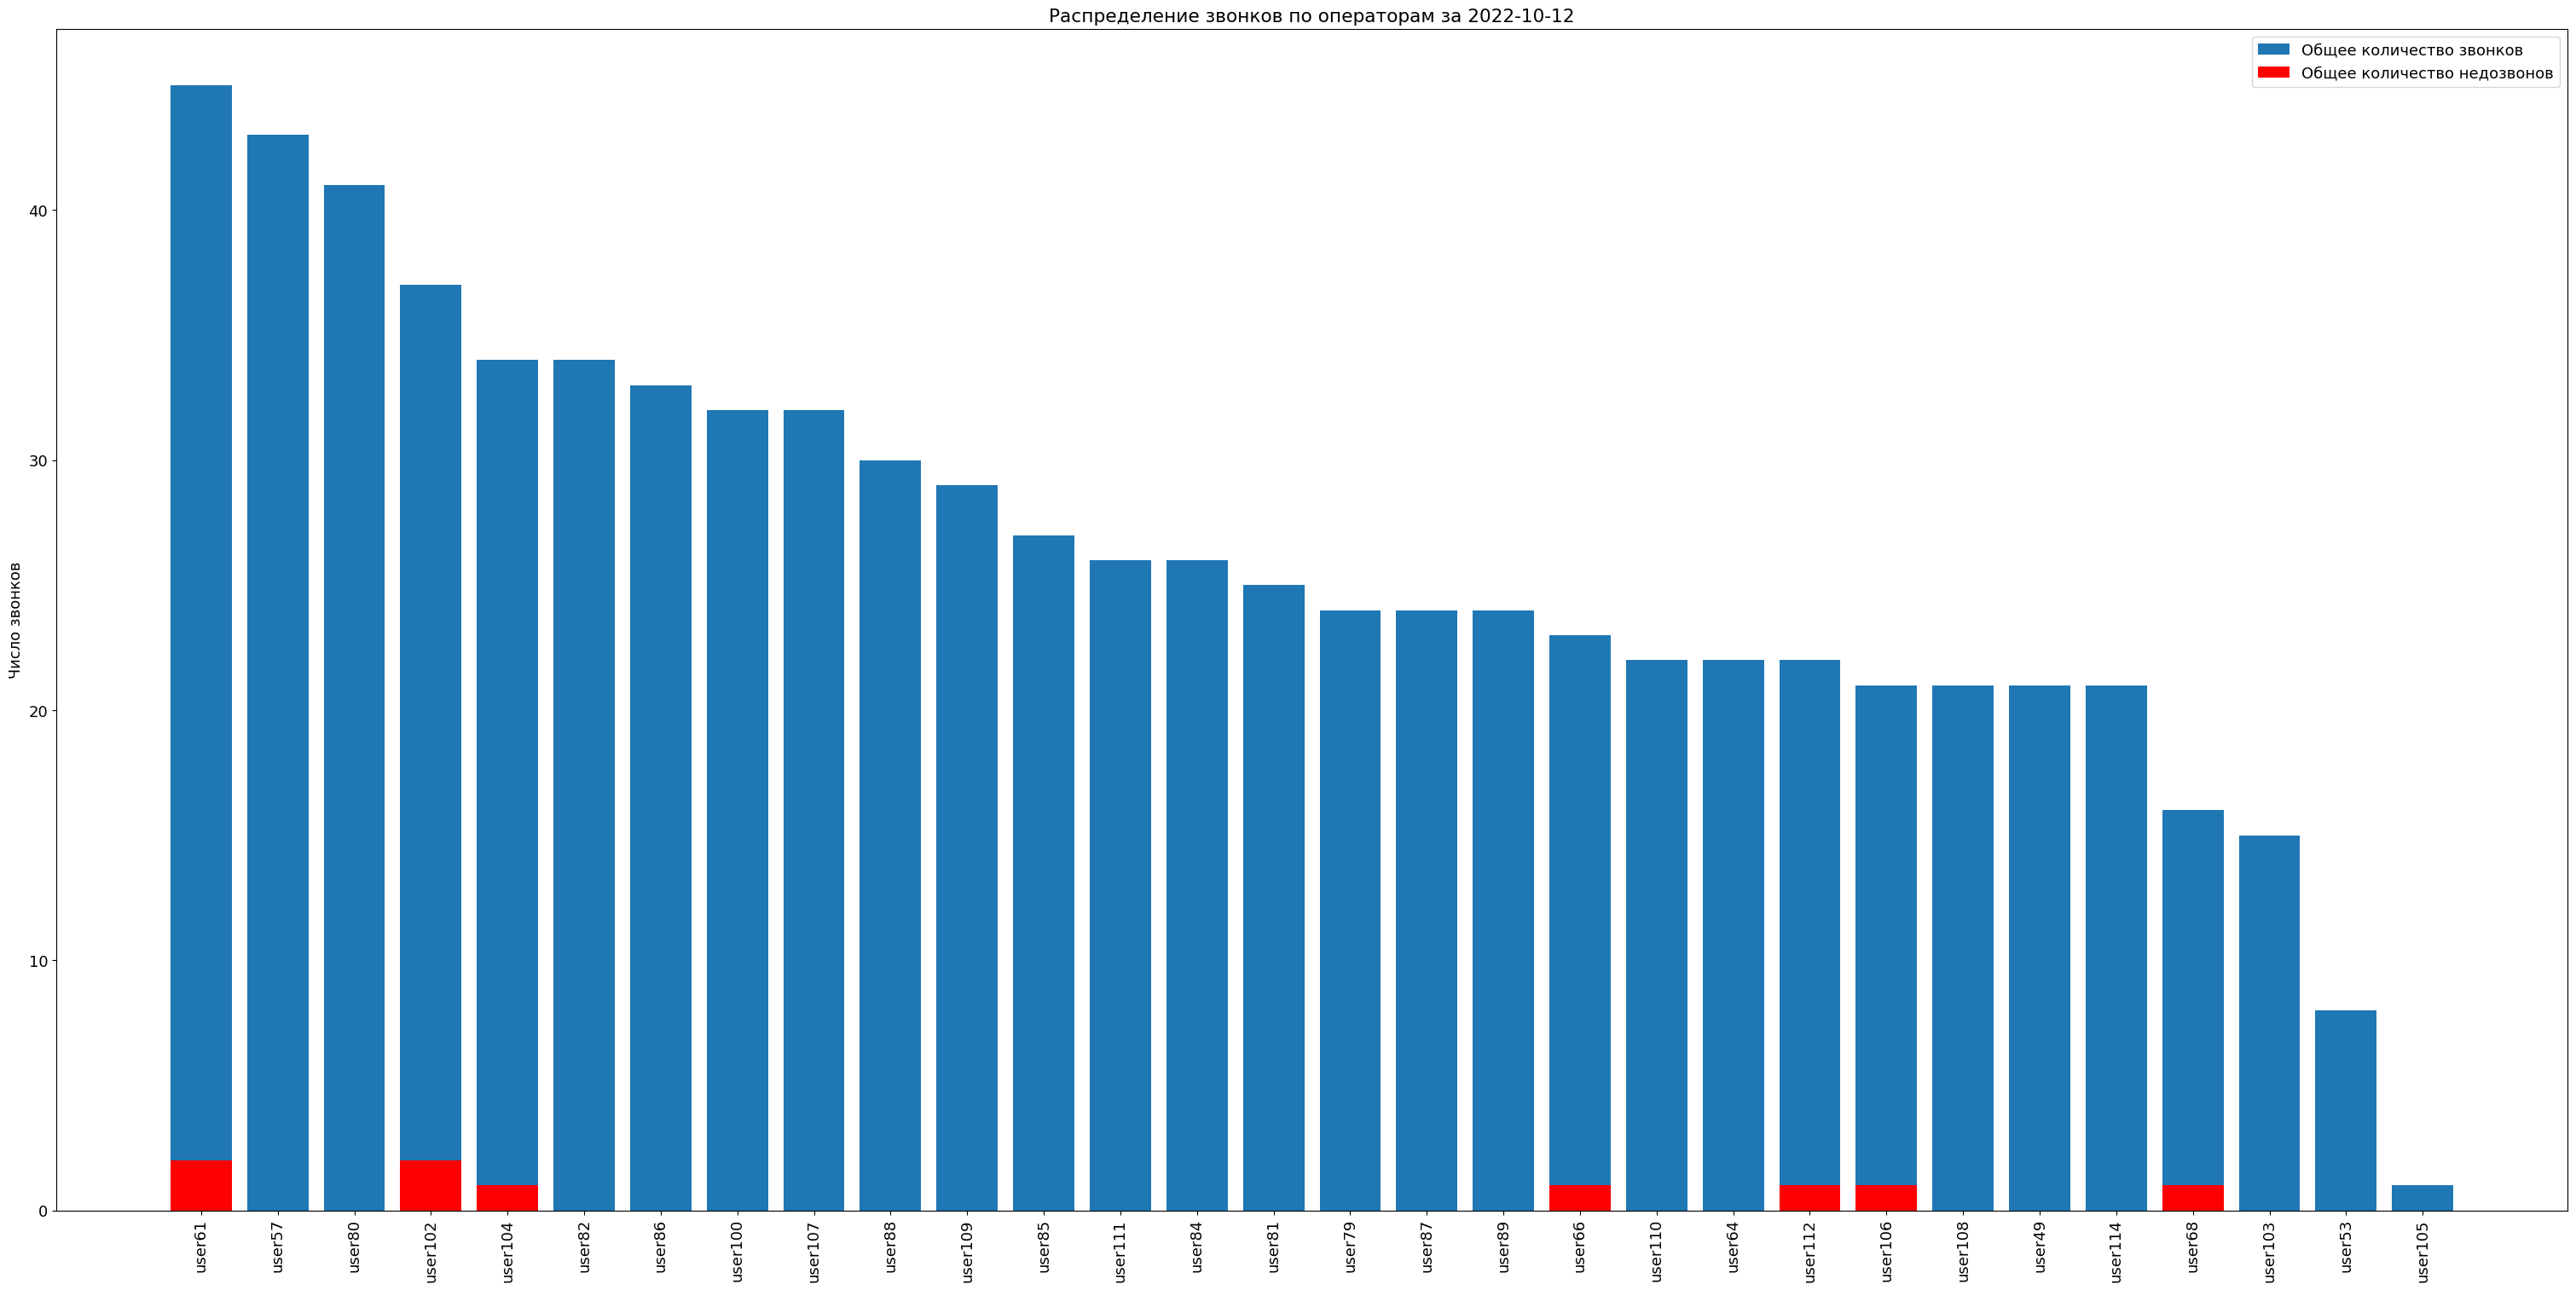

In [183]:
all_calls = stress_on_oper.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls_oper = stress_on_oper[stress_on_oper['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls['Оператор'], all_calls['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls_oper['Оператор'], didnot_calls_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Распределение звонков по операторам за конкретную дату по второму домену (ВМК2)

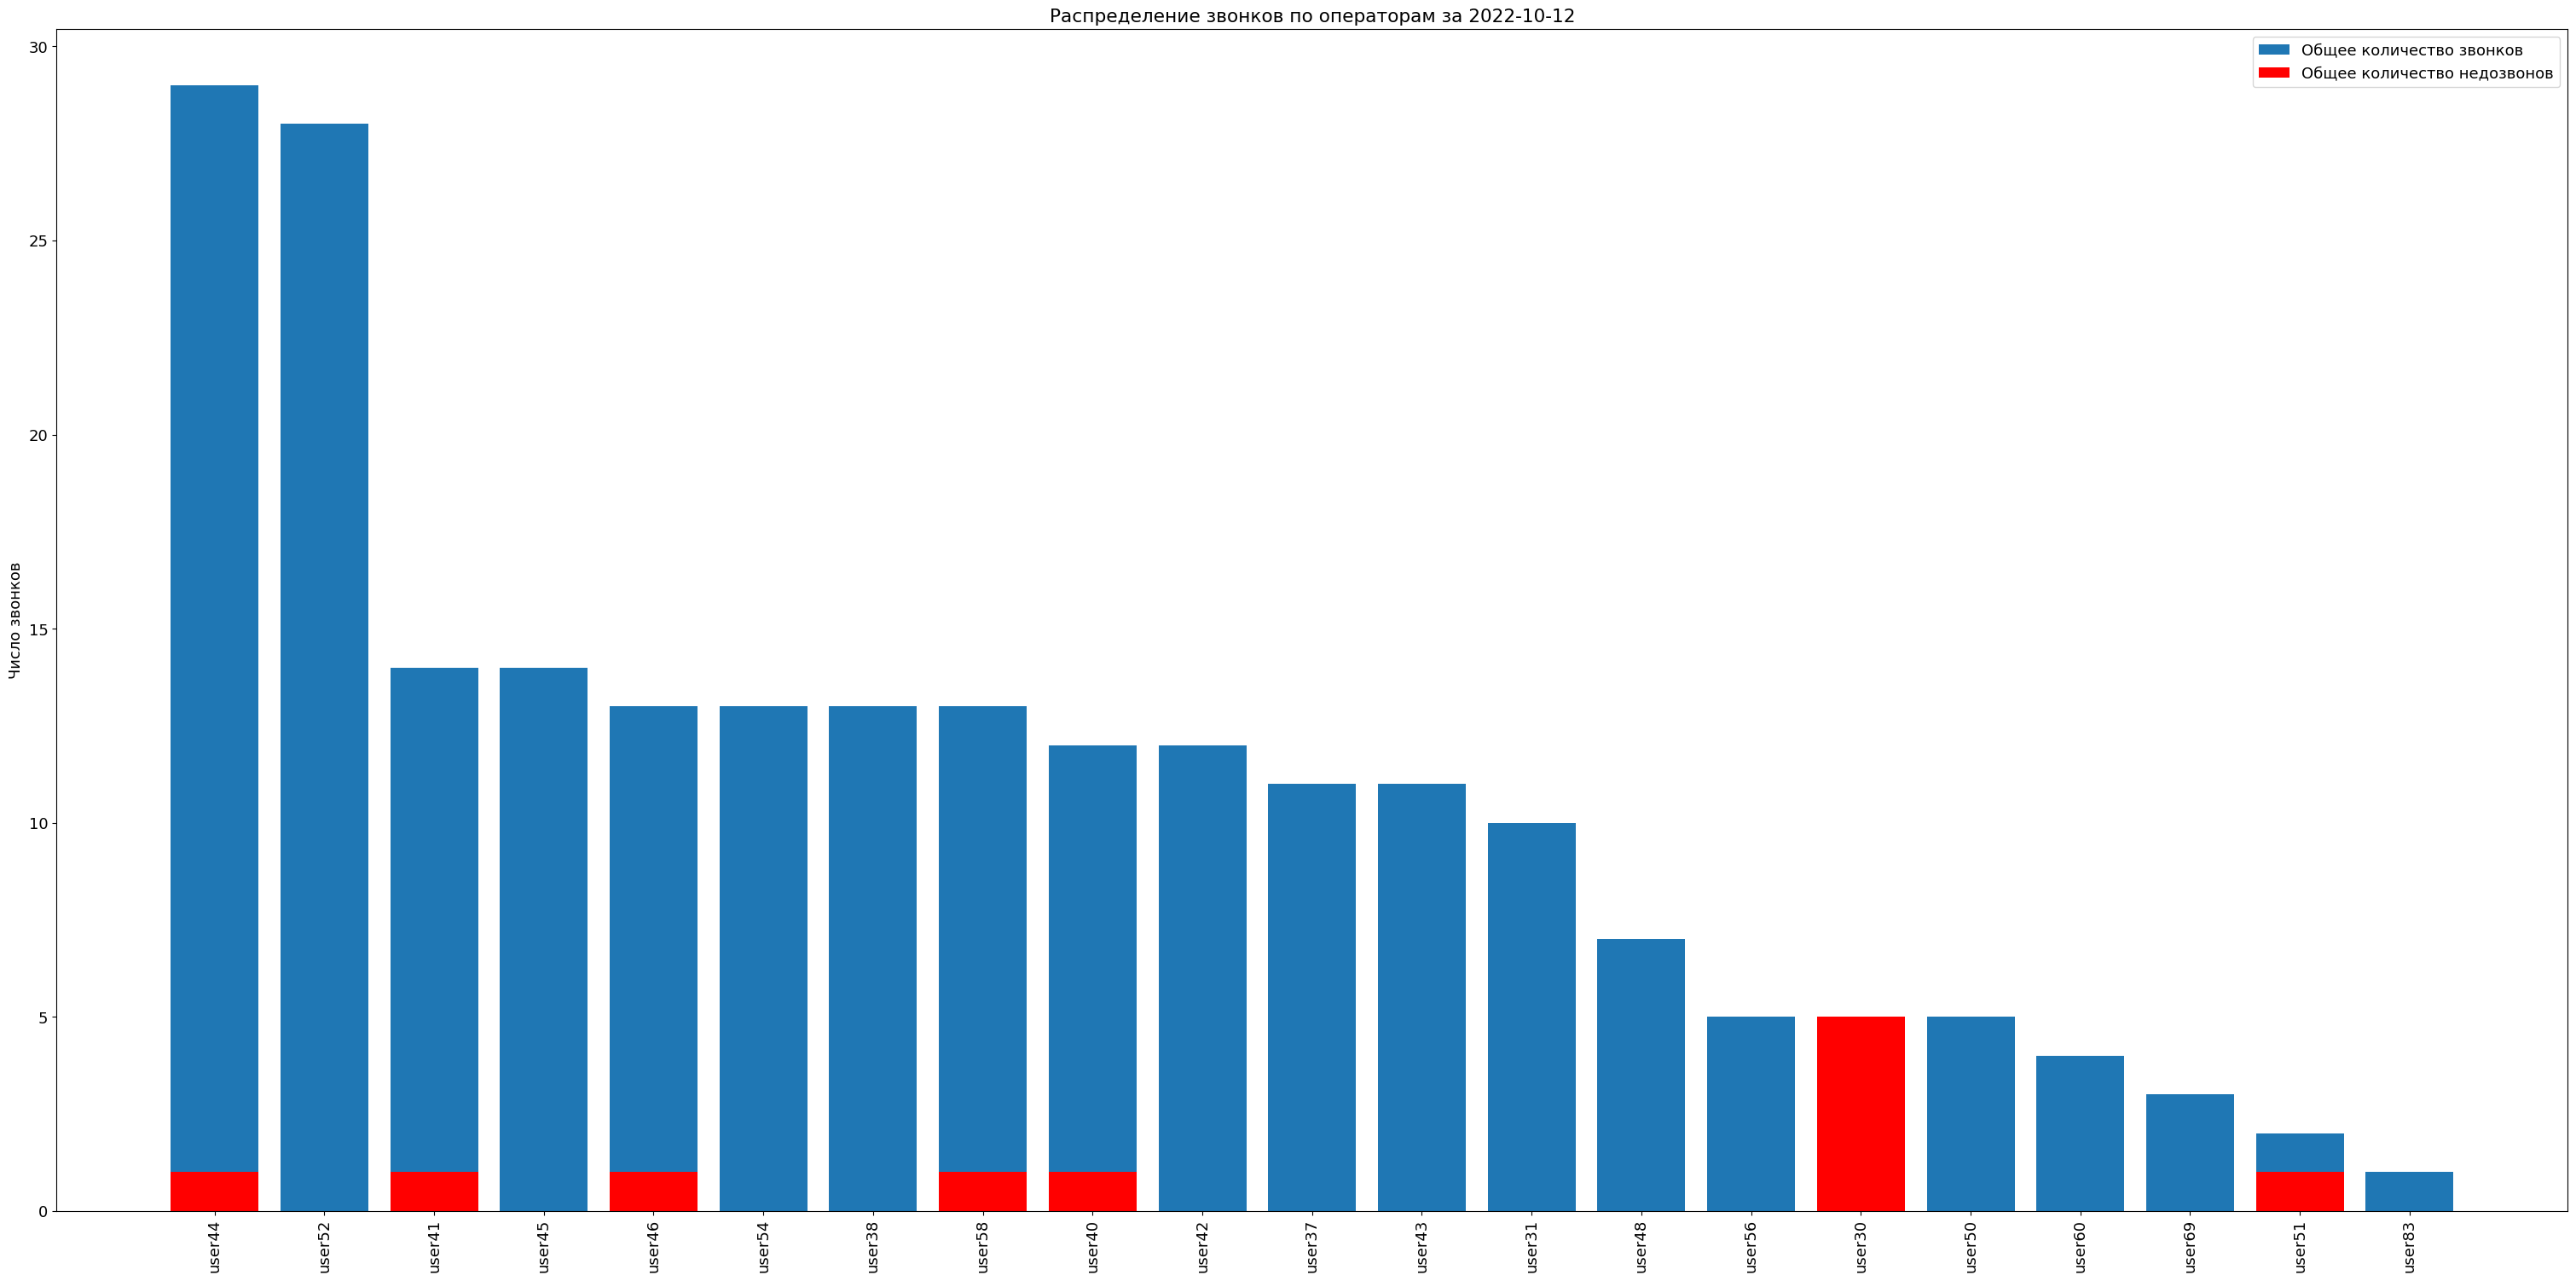

In [184]:
all_calls2 = stress_on_oper2.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls2_oper = stress_on_oper2[stress_on_oper2['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls2['Оператор'], all_calls2['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls2_oper['Оператор'], didnot_calls2_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date2))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (ВМК2)

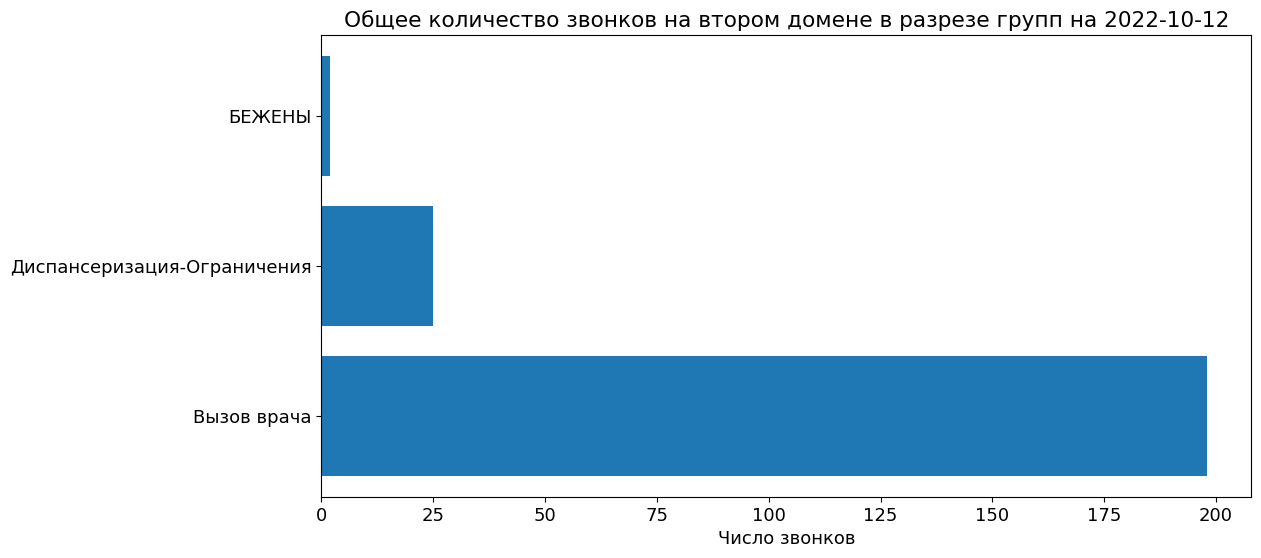

In [185]:
# Общее количество звонков на втором домене в разрезе групп
group_calls2=df_specific_day2.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls2['Группа'], group_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (Круговая диаграмма) (ВМК2)

Общее количество звонков на втором домене в разрезе групп на 2022-10-12


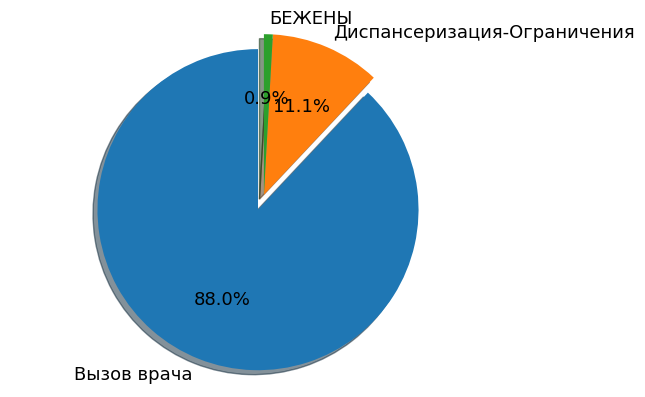

In [186]:
vals = group_calls2['Число звонков']
labels = group_calls2['Группа']
explode = tuple([0.1 if x == 0 else 0 for x in range(len(labels))])
fig, ax = plt.subplots()

ax.pie(vals, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis("equal")
print(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

### Динамика звонков по часам за конкретную дату на первом домене (ВМК)

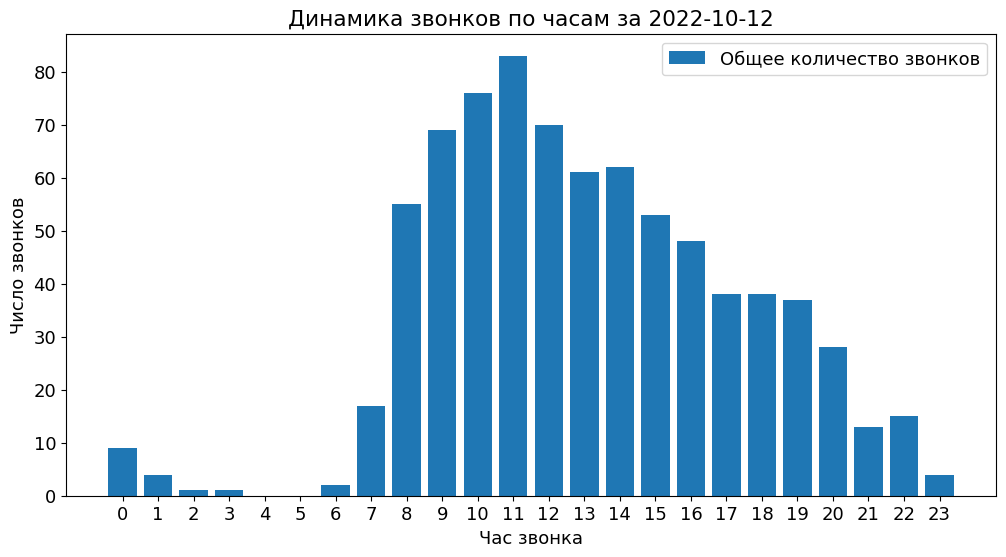

In [187]:
count_calls = df_specific_day.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls['Час звонка'], count_calls['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам за {reporting_date}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(0,24,1))
plt.legend()
plt.show()

### Динамика звонков по часам за конкретную дату на втором домене (ВМК2)

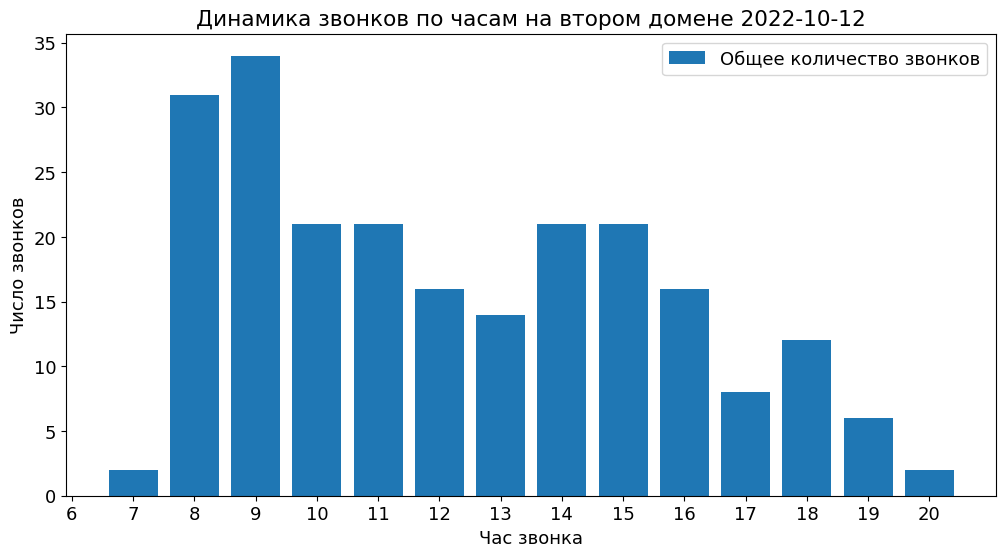

In [188]:
count_calls2 = df_specific_day2.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls2['Час звонка'], count_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам на втором домене {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(6,21,1))
plt.legend()
plt.show()

# РОСТЕЛЕКОМ первый домен

### Считаем статистику по первому домену

In [189]:
calculate_statistics_WMK(df_specific_day)
calculate_statistics_RT(df_specific_day_RT)
print(f"\nСтатистика по частичной мобилизации в РФ (по номеру 122) за {DAY_STATICTICS_CALCULATION_VMK1.strftime('%d.%m.%Y')} на {dt.datetime.now().strftime('%H:%M')}")
print_calculate_statistics_WMK_mob(calculate_values_for_report_vmk(df=df_specific_day_mob))

print("\n\n", df_specific_day_RT)
#total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]

table_RT = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого']=='78442325552') & (df_specific_day_RT['Дата вызова']==dayRT) & (df_specific_day_RT['Статус']=='пропущенный')]
table_RT['Длительность'] = table_RT['Длительность'].apply(lambda value: round(value / 60, 1))
table_RT['Дата вызова']  = table_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
table_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные.xlsx"), index=False)


Информация по вызовам по состоянию на 08:21 за 12.10.2022.
Максимальное время ожидания за сутки (мин): 3.3 (Оператор: user66, Группа: Мобилизация, Время звонка: 19:57:15))
        
По выгрузке Ростелекома: неотвеченных вызовов - 0.23 %
Всего вызовов – 883, неотвеченных – 2 (отфильтровано менее 120 сек, а также по группе "Не определена").

Статистика по частичной мобилизации в РФ (по номеру 122) за 12.10.2022 на 08:21
1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 498
2. SL за 10 сек., %: 95.18
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 3.3
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.6


     Дата вызова Время вызова Номер вызывающего Номер вызываемого Оператор  \
0    2022-10-12     23:43:48      +79370850271       78442325552   user57   
1    2022-10-12     23:3

C:\Users\Admin\AppData\Local\Temp\ipykernel_10592\3858772275.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_RT['Длительность'] = table_RT['Длительность'].apply(lambda value: round(value / 60, 1))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10592\3858772275.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_RT['Дата вызова']  = table_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))


### Данные о мобилизации (ВМК + Ростелеком)

In [190]:
dict_values_for_report_mob_vmk = calculate_values_for_report_vmk(df_specific_day_mob)

print(f"   Статистика по частичной мобилизации в РФ (по номеру 122) за {DAY_STATICTICS_CALCULATION_VMK1.strftime('%d.%m.%Y')}")
print_calculate_statistics_WMK_mob(dict_values_for_report_mob_vmk)

df_specific_day_mob_report_columns='Отчетная дата	Субъект РФ	Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации	SL за10 сек., %	Количество потерянных вызовов на линии консультаций по вопросам частичной мобилизации	Процент потерянных вызовов на линии консультаций по вопросам частичной мобилизации, %	Количество потерянных вызовов с уникальных абонентских номеров на линии консультаций по вопросам частичной мобилизации	Количество успешных обратных звонков недозвонившимся пользователям	Процент пользователей, которым не осуществлён обратный успешный звонок	Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации, мин	Среднее время ожидания на линии консультаций по вопросам частичной мобилизации, мин.	Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации, мин	Число вызовов поступивших на линию консультаций по вопросам частичной мобилизации в нерабочее время (для КЦ не имеющих круглосуточные смены обслуживания)	Наличие круглосуточной смены обслуживания линии консультаций по вопросам частичной мобилизации	Используемая операторами 122 версия (дата) скрипта для консультаций по вопросам частичной мобилизации	Количество операторов занятых на обслуживании линии консультаций по вопросам частичной мобилизации'.split("\t")

# Дополнительные расчеты по DataFrame - table_RT
table_RT_mobiliz = table_RT[table_RT['Группа'] == 'кнопка 1']
unique_phone_number_table_RT_mobiliz = table_RT_mobiliz.drop_duplicates(subset='Номер вызывающего')

number_unanswered_call = table_RT_mobiliz.shape[0]
number_unique_unanswered_call = unique_phone_number_table_RT_mobiliz.shape[0]

# Создание результирующей таблицы
df_specific_day_mob_report = pd.DataFrame([[DAY_STATICTICS_CALCULATION_VMK1.strftime("%d.%m.%Y"), 'Волгоградская область', 
dict_values_for_report_mob_vmk.get('total_number_calls'), dict_values_for_report_mob_vmk.get('SL_for_10_minutes'), 
number_unanswered_call, round(number_unanswered_call / dict_values_for_report_mob_vmk.get('total_number_calls') * 100, 2),
number_unique_unanswered_call, number_unique_unanswered_call, 0.0, 
dict_values_for_report_mob_vmk.get('max_time_wait_call'), dict_values_for_report_mob_vmk.get('mean_time_wait_call'), 
dict_values_for_report_mob_vmk.get('mean_time_talked_on_phone'), 0, 'да', 
DAY_STATICTICS_CALCULATION_VMK1.strftime("%d.%m.%Y"), 51]], columns=df_specific_day_mob_report_columns)

df_specific_day_mob_report.to_excel(os.path.join(PATH_REPORTS,"Инструкция_ЧМ_Волгоградская_область.xlsx"), index=False)
df_specific_day_mob_report

   Статистика по частичной мобилизации в РФ (по номеру 122) за 12.10.2022
1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 498
2. SL за 10 сек., %: 95.18
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 3.3
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.6


,Отчетная дата,Субъект РФ,Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации,"SL за10 сек., %",Количество потерянных вызовов на линии консультаций по вопросам частичной мобилизации,"Процент потерянных вызовов на линии консультаций по вопросам частичной мобилизации, %",Количество потерянных вызовов с уникальных абонентских номеров на линии консультаций по вопросам частичной мобилизации,Количество успешных обратных звонков недозвонившимся пользователям,"Процент пользователей, которым не осуществлён обратный успешный звонок","Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации, мин","Среднее время ожидания на линии консультаций по вопросам частичной мобилизации, мин.","Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации, мин",Число вызовов поступивших на линию консультаций по вопросам частичной мобилизации в нерабочее время (для КЦ не имеющих круглосуточные смены обслуживания),Наличие круглосуточной смены обслуживания линии консультаций по вопросам частичной мобилизации,Используемая операторами 122 версия (дата) скрипта для консультаций по вопросам частичной мобилизации,Количество операторов занятых на обслуживании линии консультаций по вопросам частичной мобилизации
0,12.10.2022,Волгоградская область,498,95.18,2,0.4,2,2,0.0,3.3,0.1,2.6,0,да,12.10.2022,51


## Считаем статистику по первому домену c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [191]:
current_day = DAY_STATICTICS_CALCULATION_FROM_8_to_8

df_specific_vmk_1 = pd.concat([load_one_table(path_storage=PATH_STORAGE_VMK, day_statictics_calculation=(current_day + dt.timedelta(1)), 
                                start_hour_job=8, end_hour_job=24, is_VMK=True), load_one_table(path_storage=PATH_STORAGE_VMK, 
                                day_statictics_calculation=(current_day + dt.timedelta(2)), 
                                start_hour_job=0, end_hour_job=8, is_VMK=True)], ignore_index=True)

df_specific_rt_1 = pd.concat([load_one_table(path_storage=PATH_STORAGE_ROSTELECOM, day_statictics_calculation=current_day, 
                                start_hour_job=8, end_hour_job=24), load_one_table(path_storage=PATH_STORAGE_ROSTELECOM, 
                                day_statictics_calculation=(current_day + dt.timedelta(1)), 
                                start_hour_job=0, end_hour_job=8)],  ignore_index=True)

calculate_statistics_WMK(df_specific_vmk_1, report_one_day=False)
calculate_statistics_RT(df_specific_rt_1)
print()
print_calculate_statistics_WMK_mob(calculate_values_for_report_vmk(df=df_specific_vmk_1[df_specific_vmk_1["Группа"] == "Мобилизация"]))


Информация по вызовам по состоянию с 8:00 12.10.2022 по 8:00 13.10.2022.
Максимальное время ожидания за сутки (мин): 28.8 (Оператор: --, Группа: Медколледж, Время звонка: 06:50:15))
        
По выгрузке Ростелекома: неотвеченных вызовов - 0.89 %
Всего вызовов – 896, неотвеченных – 8 (отфильтровано менее 120 сек, а также по группе "Не определена").

1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 506
2. SL за 10 сек., %: 93.68
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 5.1
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.6


### Отчет по максимальному времени ожидания c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [192]:
table_max_time_wait_calls_RT = table_waiting_time(df_specific_vmk_1).head(20)
table_max_time_wait_calls_RT.reset_index(inplace=True, drop=True)
table_max_time_wait_calls_RT['Дата звонка']  = table_max_time_wait_calls_RT['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
table_max_time_wait_calls_RT.to_excel(os.path.join(PATH_REPORTS, f"Отчет по макс. времени ожидания c 8_00 по 23_59 текущего дня и с 00_00 до 8_00 следущего (ВМК).xlsx"), index=False)
table_max_time_wait_calls_RT

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,13.10.2022,7.844563e+08,06:50:15,00:28:48,Медколледж,--,Не дождался
1,13.10.2022,7.960886e+10,07:38:39,00:05:05,Мобилизация,user57,Не дождался
2,13.10.2022,7.902364e+10,07:40:18,00:03:46,Мобилизация,user57,Завершён оператором
3,13.10.2022,7.919791e+10,07:37:39,00:03:17,Мобилизация,user57,Завершён оператором
4,12.10.2022,7.901130e+10,19:57:15,00:03:16,Мобилизация,user66,Не дождался
5,12.10.2022,7.904775e+10,22:37:05,00:03:14,Мобилизация,--,Не дождался
6,13.10.2022,7.904438e+10,07:02:28,00:02:32,Медколледж,--,Не дождался
7,12.10.2022,7.844644e+10,20:02:36,00:02:31,Медколледж,user80,Завершён оператором
8,13.10.2022,7.961683e+10,07:41:47,00:02:24,Мобилизация,user64,Не дождался
9,13.10.2022,7.904421e+10,05:51:58,00:02:00,Медколледж,--,Не дождался


### Отчет по неотвеченным c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [193]:
table_unanswered_calls_RT = df_specific_rt_1[(df_specific_rt_1['Номер вызываемого']== '78442325552') & (df_specific_rt_1['Статус'] == 'пропущенный')]
table_unanswered_calls_RT.reset_index(inplace=True, drop=True)
table_unanswered_calls_RT['Дата вызова']  = table_unanswered_calls_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
table_unanswered_calls_RT['Длительность'] = table_unanswered_calls_RT['Длительность'].apply(lambda value: round(value / 60, 1)) 
table_unanswered_calls_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные c 8_00 по 23_59 текущего дня и с 00_00 до 8_00 следующего дня.xlsx"), index=False)
table_unanswered_calls_RT

C:\Users\Admin\AppData\Local\Temp\ipykernel_10592\2738627049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_unanswered_calls_RT['Дата вызова']  = table_unanswered_calls_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10592\2738627049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_unanswered_calls_RT['Длительность'] = table_unanswered_calls_RT['Длительность'].apply(lambda value: round(value / 60, 1))


,Дата вызова,Время вызова,Номер вызывающего,Номер вызываемого,Оператор,Статус,Длительность,Группа,День недели,Час звонка,Наименование учреждения,Единый номер,Поставшик услуг
0,12.10.2022,22:36:44,+79047746189,78442325552,Не определен,пропущенный,3.6,кнопка 1,2,22,NaN,NaN,NaN
1,12.10.2022,19:56:46,+79011300611,78442325552,Не определен,пропущенный,3.8,кнопка 1,2,19,NaN,NaN,NaN
2,13.10.2022,07:41:38,+79616826499,78442325552,Не определен,пропущенный,2.5,кнопка 1,3,7,NaN,NaN,NaN
3,13.10.2022,07:38:13,+79608863895,78442325552,Не определен,пропущенный,5.5,кнопка 1,3,7,NaN,NaN,NaN
4,13.10.2022,07:01:26,+79044379485,78442325552,Не определен,пропущенный,3.6,Медколледж,3,7,NaN,NaN,NaN
5,13.10.2022,06:49:13,+784456304,78442325552,Не определен,пропущенный,29.8,Медколледж,3,6,NaN,NaN,NaN
6,13.10.2022,05:50:56,+79044211229,78442325552,Не определен,пропущенный,3.0,Медколледж,3,5,NaN,NaN,NaN
7,13.10.2022,04:15:38,+79921519006,78442325552,Не определен,пропущенный,120.0,Медколледж,3,4,NaN,NaN,NaN


# СЦ МКС (коронавирус)

In [194]:
# Удаление звонков по мобилизации из основных групп
df_specific_day_drop_group_mobiliz = df_specific_day.drop(df_specific_day[df_specific_day['Группа'] == 'Мобилизация'].index)
df_specific_day_RT_drop_group_mobiliz = df_specific_day_RT.drop(df_specific_day_RT[df_specific_day_RT['Группа'] == 'кнопка 1'].index)

### Считаем статистику для СЦ МКС по первому домену (ВМК) 

In [195]:

calculate_statistics(df_specific_day_drop_group_mobiliz,'Данные по первому домену')

Данные по первому домену
за 2022-10-12

Информация за сутки: 

Число операторов всего: 10,
Всего звонков 286, неотвеченных вызовов: 6
Среднее время разговора за сутки (мин): 1.7
Максимальное время ожидания за сутки (мин): 2.5 (Оператор: user80, Группа: Медколледж, Время звонка: 20:02:36)
Среднее время ожидания за сутки(мин): 0.09295
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 10, из них 10 отвечали на звонки
Днем позвонили 286 раз, из них неотвеченных вызовов: 6
Среднее время разговора денём (мин): 1.7
Максимальное время ожидания днём (мин): 2.5 (Оператор: user80, Группа: Медколледж, Время звонка: 20:02:36)
Среднее время ожидания днём (мин): 0.09295
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожидани

### Отчет по максимальному времени ожидания СЦ МКС

In [196]:
report_CS_MKS_max_time_wait_calls_vmk = table_waiting_time(df_specific_day_drop_group_mobiliz).head(20)
report_CS_MKS_max_time_wait_calls_vmk.reset_index(inplace=True, drop=True)
report_CS_MKS_max_time_wait_calls_vmk['Дата звонка']  = report_CS_MKS_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
report_CS_MKS_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания для СЦ МКС (ВМК).xlsx"), index=False)
report_CS_MKS_max_time_wait_calls_vmk

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,12.10.2022,7.844644e+10,20:02:36,00:02:31,Медколледж,user80,Завершён оператором
1,12.10.2022,7.960887e+10,20:34:08,00:00:52,Медколледж,--,Не дождался
2,12.10.2022,7.904411e+10,20:04:01,00:00:44,Медколледж,--,Не дождался
3,12.10.2022,7.966785e+10,12:45:34,00:00:36,Медколледж,user84,Завершён абонентом
4,12.10.2022,7.927507e+10,12:43:09,00:00:35,Медколледж,user82,Завершён абонентом
5,12.10.2022,7.844225e+10,14:21:12,00:00:27,Медколледж,user104,Переведён
6,12.10.2022,7.937738e+10,21:16:30,00:00:14,Медколледж,user80,Завершён абонентом
7,12.10.2022,7.844273e+10,08:05:44,00:00:14,Медколледж,user104,Завершён оператором
8,12.10.2022,7.996510e+10,16:00:27,00:00:13,Медколледж,user104,Завершён оператором
9,12.10.2022,7.844225e+10,09:33:37,00:00:12,Медколледж,user84,Завершён абонентом


### Отчет по неотвеченным звонкам СЦ МКС

In [223]:
table_unanswered_call_RT = table_RT.drop(table_RT[table_RT['Группа'] == 'кнопка 1'].index)
table_unanswered_call_RT.reset_index(inplace=True, drop=True)
table_unanswered_call_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные СЦ МКС.xlsx"), index=False)
table_unanswered_call_RT

,Дата вызова,Время вызова,Номер вызывающего,Номер вызываемого,Оператор,Статус,Длительность,Группа,День недели,Час звонка,Наименование учреждения,Единый номер,Поставшик услуг


### Статистика для СЦ МКС

In [198]:
calculate_statistics_WMK(df_specific_day_drop_group_mobiliz)
calculate_statistics_RT(df_specific_day_RT_drop_group_mobiliz)


Информация по вызовам по состоянию на 08:21 за 12.10.2022.
Максимальное время ожидания за сутки (мин): 2.5 (Оператор: user80, Группа: Медколледж, Время звонка: 20:02:36))
        
По выгрузке Ростелекома: неотвеченных вызовов - 0.0 %
Всего вызовов – 392, неотвеченных – 0 (отфильтровано менее 120 сек, а также по группе "Не определена").


#  Общее Ростелеком

### Распределение звонков по операторам

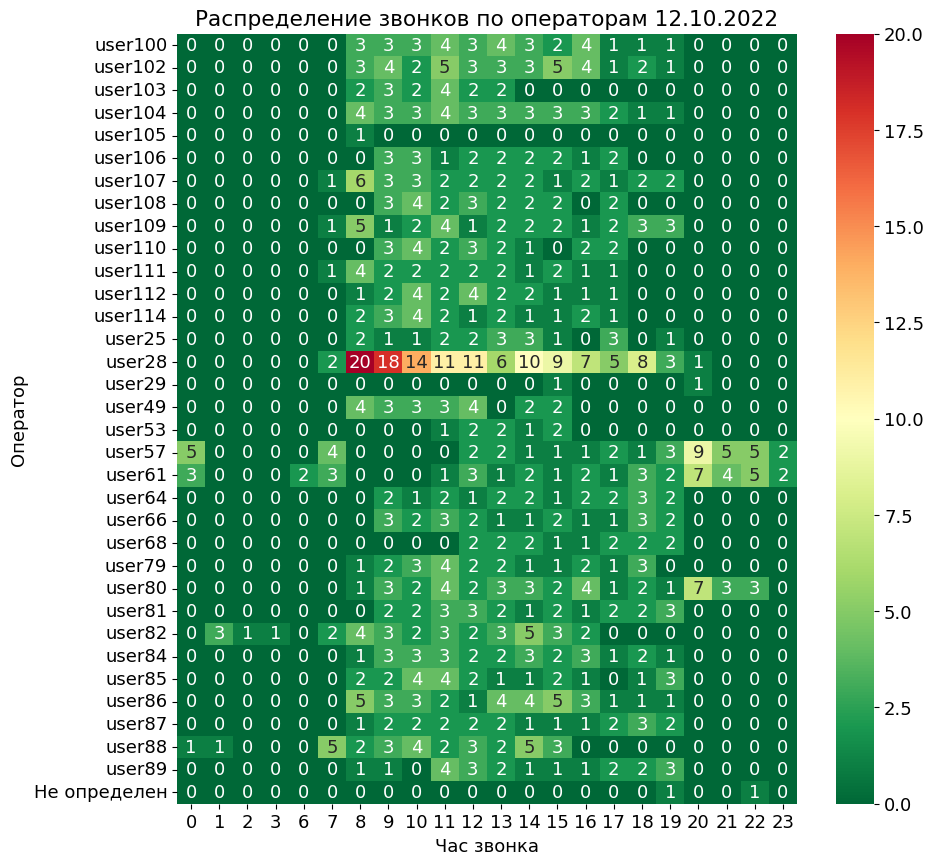

In [199]:
################################################################################################
tmp = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого'] =='78442325552') & (df_specific_day_RT['Оператор']!='user8') & (df_specific_day_RT['Оператор']!='user9')]

f = plt.figure(figsize=(10,10))
heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Распределение звонков по операторам '+ DAY_STATICTICS_CALCULATION_ROSTELECOM.strftime('%d.%m.%Y'))

plt.show()

### Обшее количество недозвонов по часам

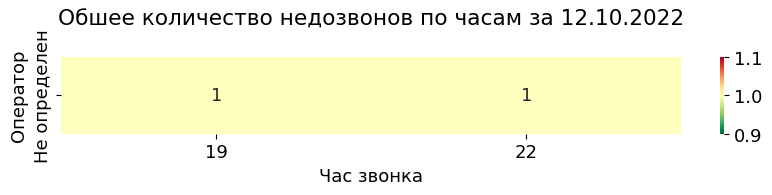

In [200]:
if tmp[tmp['Оператор']=='Не определен'].empty:
    print("Нет пропущенных звонков")        
else:        
    temp2 = tmp[tmp['Оператор']=='Не определен']
    f = plt.figure(figsize=(10,1))
    heatmap_plot = sns.heatmap(pd.crosstab(temp2['Оператор'], temp2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
    plt.title('Обшее количество недозвонов по часам за '+ DAY_STATICTICS_CALCULATION_ROSTELECOM.strftime('%d.%m.%Y' + '\n'))
    plt.show('Не определен')

### Общее количество звонков на первом домене в разрезе групп

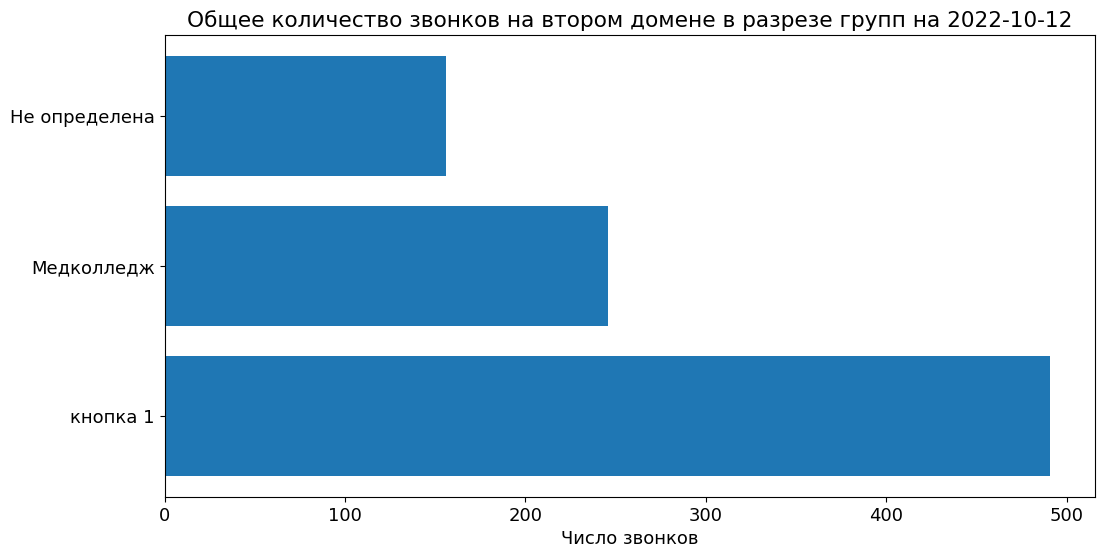

In [201]:
group_calls_RT=df_specific_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls_RT['Группа'], group_calls_RT['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на первом домене в разрезе групп (Круговая диаграмма)

Общее количество звонков на первом домене в разрезе групп на 2022-10-12


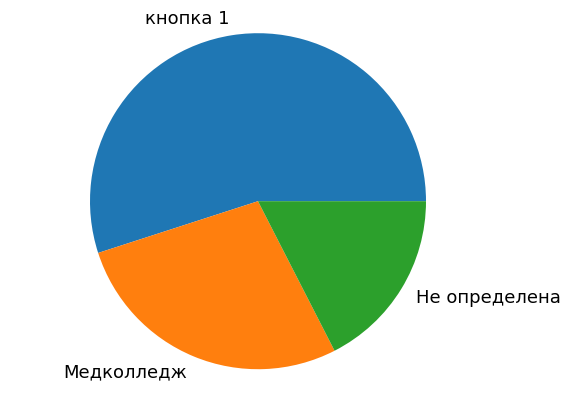

In [202]:
vals = group_calls_RT['Число звонков']
labels = group_calls_RT['Группа']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
print(f'Общее количество звонков на первом домене в разрезе групп на {dayRT}')

## Отчёт для ЕА

In [203]:
report_for_EA(df_specific_day, df_specific_day_RT)

Информация по вызовам на "122" за 12.10.2022:
Всего вызовов: 883
Неотвеченных вызовов: 2 ( 0,23%, зеленая зона)
Среднее время ожидания: 0,097 мин. (зеленая зона)



# Загрузка архивных данных ВМК, ВМК2 и Ростелеком

In [204]:
names= glob.glob(PATH_STORAGE_VMK + "*", recursive=True)
names2= glob.glob(PATH_STORAGE_VMK2 + "*", recursive=True)
namesRT = glob.glob(PATH_STORAGE_ROSTELECOM + "*", recursive=True)

# Загрузка всех данных ВМК
total_all_days = create_df(names)
total_all_days['Группа']=total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})

# Загрузка всех данных ВМК2
total_all_days2 = create_df(names2)
total_all_days2['Группа']=total_all_days2['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})

# Загрузка всех данных Ростелеком

contRT=[]
for i in range(len(namesRT)):
    
    date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', namesRT[i]).group()
    df_RT = pd.read_excel(namesRT[i],dtype={'Номер вызывающего': str})
    if (dt.datetime.strptime(date, "%Y-%m-%d")<dt.datetime(2021,4,22)):
        df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
    else:
        df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
    df_RT=df_RT[df_RT['Длительность'] > 9]
    
    df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
    df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
    df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
    df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
    df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
    df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
    df_RT['Время вызова']=df_RT['Время вызова'].dt.time    
    contRT.append(df_RT)
    
total_all_days_RT = pd.concat(contRT,ignore_index=True)

total_all_days_RT = total_all_days_RT.rename(columns={'Первый ответивший': 'Оператор'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].fillna('Не определена')
total_all_days_RT['Оператор']=total_all_days_RT['Оператор'].replace({' ':'Не определен'})

total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Группа'] =='Не определена') & (total_all_days_RT['Статус'] =='пропущенный')].index)
total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Длительность'] < 120) & (total_all_days_RT['Статус'] =='пропущенный')].index)

total_all_days_RT['Номер вызывающего']=total_all_days_RT['Номер вызывающего'].str.replace(' ', '')
total_all_days_RT['Номер вызываемого']=total_all_days_RT['Номер вызываемого'].str.replace(' ', '')
hospitals=pd.read_excel(os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, 'Переадресация телефонов.xlsx'))
total_all_days_RT=total_all_days_RT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')


# total_all_days.to_excel("ВМК1.xlsx", index=False)
# total_all_days2.to_excel("ВМК2.xlsx", index=False)

### Таблица максимального времени ожидания за все даты по первому домену (ВМК)

In [205]:
report_total_max_time_wait_calls_vmk = table_waiting_time(total_all_days).head(10)
report_total_max_time_wait_calls_vmk['Дата звонка']  = report_total_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
report_total_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания за весь период (ВМК).xlsx"), index=False)
report_total_max_time_wait_calls_vmk

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
1111,28.09.2022,79023839863.0,18:39:15,01:51:13,Медколледж,--,Не дождался
199,03.01.2022,78442332132.0,15:20:36,01:43:10,Медколледж,user7,Не дождался
852,09.03.2022,79889837665.0,14:25:12,01:42:16,Медколледж,user104,Не дождался
738,09.03.2022,79197919271.0,13:19:52,01:19:45,Медколледж,user112,Не дождался
742,09.03.2022,78442478160.0,13:21:33,01:17:39,Медколледж,user82,Не дождался
875,09.03.2022,79370927948.0,14:43:56,01:09:39,Медколледж,user108,Не дождался
827,09.03.2022,79275265499.0,14:05:20,01:08:00,Медколледж,user102,Не дождался
197,03.01.2022,79779816465.0,15:11:18,01:06:51,Медколледж,user10,Не дождался
903,09.03.2022,79616995557.0,15:48:31,01:04:48,Медколледж,user80,Не дождался
907,09.03.2022,79093823292.0,15:50:34,01:00:05,Медколледж,user111,Не дождался


### Таблица максимального времени ожидания за все даты по второму домену (ВМК2)

In [206]:
report_total_max_time_wait_calls_vmk2 = table_waiting_time(total_all_days2).head(10)
report_total_max_time_wait_calls_vmk2['Дата звонка']  = report_total_max_time_wait_calls_vmk2['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
report_total_max_time_wait_calls_vmk2.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания за весь период (ВМК2).xlsx"), index=False)
report_total_max_time_wait_calls_vmk2

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
14,06.02.2022,79955874425.0,07:57:08,01:07:20,Информация распространения COVID,user95,Завершён абонентом
73,22.03.2022,78443381784.0,08:44:46,01:06:21,Мониторинг больного COVID,user117,Не дождался
1815,13.02.2022,79023620629.0,19:50:49,01:05:27,Информация распространения COVID,user94,Не дождался
19,06.02.2022,79275428538.0,07:59:21,01:05:18,Информация распространения COVID,user121,Переведён
33,06.02.2022,79696504035.0,08:03:10,01:00:26,Информация распространения COVID,user93,Завершён абонентом
66,06.02.2022,79996291559.0,08:11:33,00:59:20,Информация распространения COVID,user23,Переведён
775,20.02.2022,79023113005.0,14:35:26,00:56:55,Вопросы не по COVID,--,Не дождался
4,11.10.2022,79023800788.0,06:51:16,00:53:53,Вызов врача,user52,Завершён оператором
329,28.09.2022,79377168262.0,20:14:53,00:52:43,Диспансеризация-Вопросы не по COVID,user54,Не дождался
68,06.02.2022,79026563702.0,08:12:28,00:52:37,Информация распространения COVID,user25,Переведён


In [207]:
# Что это?
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)


Empty DataFrame
Columns: [Дата звонка, Число звонков]
Index: []
0


# Отчет по количеству звонков и максимальному времени ожидания (Все группы)

In [208]:
START_DAY = dt.datetime(2022,9,1) 
END_DAY = dt.datetime(2022,9,30) 

df_all_calls_vmk = total_all_days.copy()
df_all_calls_vmk['Дата звонка'] = df_all_calls_vmk['Дата звонка'].astype('datetime64')
df_all_calls_vmk = df_all_calls_vmk[(df_all_calls_vmk['Дата звонка'] >= START_DAY) & (df_all_calls_vmk['Дата звонка'] <= END_DAY)]

df_all_calls_rostelecom = total_all_days_RT.copy()
df_all_calls_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова'] >= START_DAY) & (df_all_calls_rostelecom['Дата вызова'] <= END_DAY)]

all_days_rostelecom = list(df_all_calls_rostelecom['Дата вызова'].dt.date.unique())
all_days = list(df_all_calls_vmk['Дата звонка'].dt.date.unique())
lists_new_dt = []

for i in all_days:
    df_report = df_all_calls_vmk[df_all_calls_vmk['Дата звонка']== str(i)].copy()
    df_tmp_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова']== str(i)) & (df_all_calls_rostelecom['Номер вызываемого']=='78442325552')].copy()
    lists_new_dt.append([str(i), round(df_tmp_rostelecom['Дата вызова'].count(), 1), round(df_report['Время ожидания'].max(), 1)])
   
df_report = pd.DataFrame(lists_new_dt)
df_report = df_report.rename(columns={0: "Дата вызова", 1: "Количество звонков", 2: "Максимальное время ожидания"})


df_report.to_excel(os.path.join(PATH_REPORTS, 'Отчет по количеству звонков и макс. времени.xlsx'), index=False) 
print(df_report)

   Дата вызова  Количество звонков  Максимальное время ожидания
0   2022-09-01                 470                          0.2
1   2022-09-02                 559                          1.0
2   2022-09-05                 795                          2.6
3   2022-09-06                 642                          3.2
4   2022-09-07                 580                          0.6
5   2022-09-08                 479                          0.8
6   2022-09-09                 543                          0.8
7   2022-09-10                 203                          0.1
8   2022-09-11                 176                          0.4
9   2022-09-12                 884                          0.7
10  2022-09-13                 605                          0.7
11  2022-09-14                 575                          0.7
12  2022-09-15                 466                          1.0
13  2022-09-16                 472                          0.7
14  2022-09-17                 168      

# Отчет по количеству звонков и максимальному времени ожидания (Без группы "кнопка 1")

In [209]:
START_DAY = dt.datetime(2022,9,1) 
END_DAY = dt.datetime(2022,9,30) 

df_all_calls_vmk = total_all_days.copy()
df_all_calls_vmk['Дата звонка'] = df_all_calls_vmk['Дата звонка'].astype('datetime64')
df_all_calls_vmk = df_all_calls_vmk[(df_all_calls_vmk['Дата звонка'] >= START_DAY) & (df_all_calls_vmk['Дата звонка'] <= END_DAY)]

df_all_calls_rostelecom = total_all_days_RT.copy()
df_all_calls_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова'] >= START_DAY) & (df_all_calls_rostelecom['Дата вызова'] <= END_DAY)]

df_all_calls_rostelecom = df_all_calls_rostelecom.drop(df_all_calls_rostelecom[df_all_calls_rostelecom['Группа'] == 'кнопка 1'].index)


all_days_rostelecom = list(df_all_calls_rostelecom['Дата вызова'].dt.date.unique())
all_days = list(df_all_calls_vmk['Дата звонка'].dt.date.unique())
lists_new_dt = []

for i in all_days:
    df_report = df_all_calls_vmk[df_all_calls_vmk['Дата звонка']== str(i)].copy()
    df_tmp_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова']== str(i)) & (df_all_calls_rostelecom['Номер вызываемого']=='78442325552')].copy()
    lists_new_dt.append([str(i), round(df_tmp_rostelecom['Дата вызова'].count(), 1), round(df_report['Время ожидания'].max(), 1)])
   
df_report = pd.DataFrame(lists_new_dt)
df_report = df_report.rename(columns={0: "Дата вызова", 1: "Количество звонков", 2: "Максимальное время ожидания"})


df_report.to_excel(os.path.join(PATH_REPORTS, 'Отчет по количеству звонков и макс. времени.xlsx'), index=False) 
print(df_report)

   Дата вызова  Количество звонков  Максимальное время ожидания
0   2022-09-01                 470                          0.2
1   2022-09-02                 559                          1.0
2   2022-09-05                 795                          2.6
3   2022-09-06                 642                          3.2
4   2022-09-07                 580                          0.6
5   2022-09-08                 479                          0.8
6   2022-09-09                 543                          0.8
7   2022-09-10                 203                          0.1
8   2022-09-11                 176                          0.4
9   2022-09-12                 884                          0.7
10  2022-09-13                 605                          0.7
11  2022-09-14                 575                          0.7
12  2022-09-15                 466                          1.0
13  2022-09-16                 472                          0.7
14  2022-09-17                 168      

### Выгрузка по успешным звонкам за период

In [210]:
start_RT = '2020-11-27'
end_RT = '2022-08-22'
tmp_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()

tmp_RT.to_excel(os.path.join(PATH_REPORTS,"Отчет по успешным звонкам за период.xlsx"),  index=False)
print(f'Всего звонков: {Total}')

tmp_RT.to_excel(os.path.join(PATH_REPORTS, 'Отчет по успешным звонкам за период.xlsx'), index=False) 
tmp_RT

Всего звонков: 139721


,Дата вызова,Число звонков
0,2022-01-01,58
1,2022-01-02,115
2,2022-01-03,160
3,2022-01-04,168
4,2022-01-05,159
...,...,...
190,2022-08-16,521
191,2022-08-17,569
192,2022-08-18,491
193,2022-08-19,507


### Всего звонков

In [211]:
start_RT = '2022-01-01'
end_RT = '2022-09-28'
tmp_RT=total_all_days_RT[(total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()
# tmp_RT.to_excel("Всего звонков.xlsx")
print(f'Всего звонков: {Total}')
tmp_RT

Всего звонков: 170675


,Дата вызова,Число звонков
0,2022-01-01,58
1,2022-01-02,115
2,2022-01-03,223
3,2022-01-04,173
4,2022-01-05,160
...,...,...
223,2022-09-24,1555
224,2022-09-25,1490
225,2022-09-26,1537
226,2022-09-27,1589


### Для заполнения таблицы  комитета здравоохранения

In [222]:
# 3 Всего количество обращений (за отчетный период
# 4 Всего количество обращений (нарастающим итогом с 01.01.2022)
# 5 Количество обращений (за отчетный период) по вопросам здравоохранения (организации и оказания мед.помощи)
# 6 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам здравоохранения (организации и оказания мед.помощи)  
# 7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи)  
# 8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи)  

first_January = dt.datetime(2022,1,1)
first_January_VMK2 = dt.datetime(2022,2,7)
k8 = 36372 # истерически сложилось
k4= 6505 #1762 # истерически сложилось

# ОПРЕДЕЛЯЕМ 7 ДНЕВНЫЙ ПЕРИОД !!!
start_day=dt.datetime(2022,10,6)
finish_day=dt.datetime(2022,10,12)

# убираем переадресованные вызовы
total_all_lucky_days_RT = total_all_days_RT[total_all_days_RT['Оператор'] != 'Не определен']

# Создаём датафрейм для первого домена Ростелеком с 1 янворя 2022 года 
df_1_to_finish_day_RT = total_all_lucky_days_RT[(total_all_lucky_days_RT['Дата вызова'] >= first_January) & (total_all_lucky_days_RT['Дата вызова'] <= finish_day)]
# Удаляем данные касательно кнопки 1
df_1_to_finish_day_RT = df_1_to_finish_day_RT.drop(df_1_to_finish_day_RT[df_1_to_finish_day_RT['Группа'] == 'кнопка 1'].index)

# Создаём датафрейм для первого домена Ростелеком за определенный период 
df_period_day_RT = total_all_lucky_days_RT[(total_all_lucky_days_RT['Дата вызова'] >= start_day) & (total_all_lucky_days_RT['Дата вызова'] <= finish_day)]
# Удаляем данные касательно кнопки 1
df_period_day_RT = df_period_day_RT.drop(df_period_day_RT[df_period_day_RT['Группа'] == 'кнопка 1'].index)


# Создаём датафрейм для второго домена ВМК (Вызов врача и Вопросы не по covid-19)
df_healthcare_calls_VMK2 = total_all_days2[(total_all_days2['Группа'] == 'Вызов врача') | (total_all_days2['Группа'] == 'Вопросы не по COVID')]
# Вычеслдяем количество звонков с 1 янворя 2022 года 
count_1_to_finish_healthcare_calls_VMK2 = df_healthcare_calls_VMK2[(df_healthcare_calls_VMK2['Дата звонка'] >= first_January_VMK2.date()) & (df_healthcare_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 
# Вычеслдяем количество звонков за определенный период
count_healthcare_calls_VMK2 = df_healthcare_calls_VMK2[(df_healthcare_calls_VMK2['Дата звонка'] >= start_day.date()) & (df_healthcare_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 

# Создаём датафрейм для второго домена ВМК по вопросам covid - 19 (Информация распространения COVID и Мониторинг больного COVID)
df_covid_calls_VMK2 = total_all_days2[(total_all_days2['Группа'] == 'Информация распространения COVID') | (total_all_days2['Группа'] == 'Мониторинг больного COVID')]

# Вычеслдяем количество звонков по вопросам covid - 19 с 1 янворя 2022 года 
count_1_to_covid_calls_VMK2 = df_covid_calls_VMK2[(df_covid_calls_VMK2['Дата звонка'] >= first_January_VMK2.date()) & (df_covid_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0]
# Вычеслдяем количество звонков по вопросам covid - 19
count_covid_calls_VMK2 = df_covid_calls_VMK2[(df_covid_calls_VMK2['Дата звонка'] >= start_day.date()) & (df_covid_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 

print(f"""3 Всего количество обращений (c {start_day.day} по {finish_day.day} число): {df_period_day_RT.shape[0]}
4 Всего количество обращений (c нарастающим итогом с 01.01.2022 по {finish_day.day} число): {df_1_to_finish_day_RT.shape[0] + k4}
5 Количество обращений (c {start_day.day} по {finish_day.day} число) по вопросам здравоохранения: {count_healthcare_calls_VMK2}
6 Количество обращений (c нарастающим итогом с 01.01.2022 по {finish_day.day} число)по вопросам здравоохранения: {count_1_to_finish_healthcare_calls_VMK2}
7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи): {count_covid_calls_VMK2}
8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи): {count_1_to_covid_calls_VMK2 + k8}

""")
print(pd.DataFrame([{"3": df_period_day_RT.shape[0],"4": df_1_to_finish_day_RT.shape[0] + k4,"5": count_healthcare_calls_VMK2,"6": count_1_to_finish_healthcare_calls_VMK2,"7": count_covid_calls_VMK2, "8": count_1_to_covid_calls_VMK2 + k8}], index=[' ']))

3 Всего количество обращений (c 6 по 12 число): 2392
4 Всего количество обращений (c нарастающим итогом с 01.01.2022 по 12 число): 167862
5 Количество обращений (c 6 по 12 число) по вопросам здравоохранения: 1244
6 Количество обращений (c нарастающим итогом с 01.01.2022 по 12 число)по вопросам здравоохранения: 62193
7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи): 1
8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи): 58406


      3       4     5      6  7      8
   2392  167862  1244  62193  1  58406


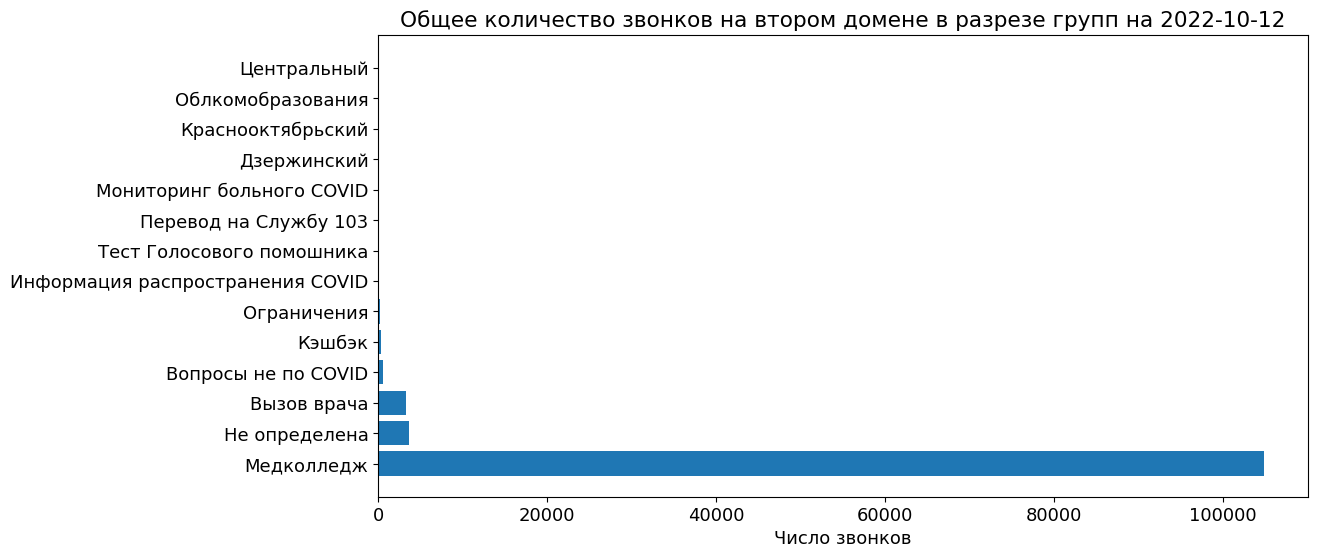

In [213]:
##################################################


startDayRT=dt.datetime(2022,1,1) 
endDayRT=dt.datetime(2022,3,31) 
 
df_med_day_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(startDayRT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(endDayRT))] 
 
df_med_day_RT 
 
group_calls_RT2=df_med_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False) 
 
f = plt.figure(figsize=(12,6)) 
plt.barh(group_calls_RT2['Группа'], group_calls_RT2['Число звонков'],label='Общее количество звонков') 
 
plt.xlabel('Число звонков') 
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}') 
 
plt.rcParams.update({'font.size': 13}) 
plt.show()
# df_med_day_RT['Дата вызова'].to_excel("1PT.xlsx")
# group_calls_RT2.to_excel("Первый домен РТ.xlsx")

d:\01_Материалы_для_саморазвития\01_Разработка\Python\Program\pvenv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


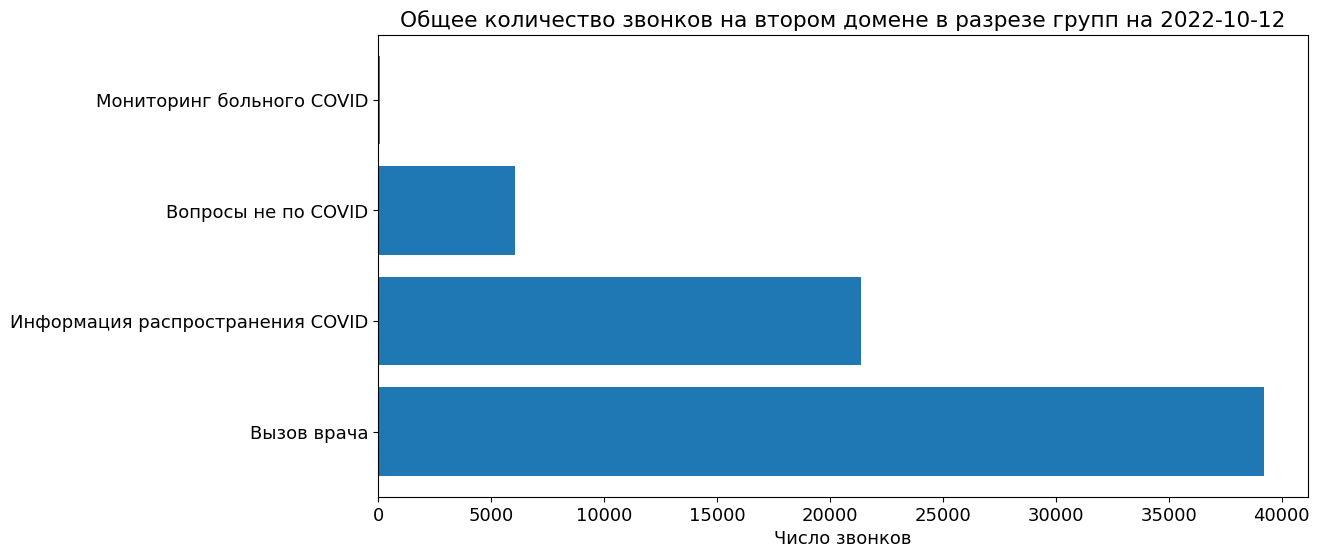

In [214]:

df_med_day_WMK=total_all_days2[(total_all_days2['Дата звонка']>=pd.to_datetime(startDayRT)) & (total_all_days2['Дата звонка']<=pd.to_datetime(endDayRT))] 
 
df_med_day_WMK 
 
group_calls_WMK=df_med_day_WMK.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False) 

f = plt.figure(figsize=(12,6)) 
plt.barh(group_calls_WMK['Группа'], group_calls_WMK['Число звонков'],label='Общее количество звонков') 
 
plt.xlabel('Число звонков') 
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}') 
 
plt.rcParams.update({'font.size': 13}) 
plt.show()

# group_calls_WMK.to_excel("Второй домен ВМК.xlsx")


### Количество звноков по мобилизации за период

In [215]:
start_day_report = dt.datetime(2022,9,22) 
end_day_report = dt.datetime(2022,10,12) 

df_report = total_all_days[(total_all_days['Час звонка'] >= START_HOUR_JOB) & (total_all_days['Час звонка'] < END_HOUR_JOB) & (total_all_days['Дата звонка'] >= start_day_report.date()) & (total_all_days['Дата звонка'] <= end_day_report.date()) & (total_all_days["Группа"] == "Мобилизация")].copy()
number_calls = df_report.shape[0]

# start_day_report = dt.datetime.combine(df_report['Дата звонка'].min(), dt.time())
# end_day_report = dt.datetime.combine(df_report['Дата звонка'].max(), dt.time())
report_list = list()

values_for_report_mob_vmk_all = {}
start_day_report_ = start_day_report
while start_day_report_ <= end_day_report:
    values_for_report_mob_vmk = calculate_values_for_report_vmk(df_report[df_report['Дата звонка'] == start_day_report_.date()])
    
    # Создан костыль из-за необходимости ручной корректировки даты: 2022-10-01	
    if start_day_report_ != dt.datetime(2022,10,1): 
        report_list.append([start_day_report_.date().strftime('%d.%m.%Y'), values_for_report_mob_vmk.get('total_number_calls'), 
                            values_for_report_mob_vmk.get('SL_for_10_minutes'), values_for_report_mob_vmk.get('max_time_wait_call'), 
                            values_for_report_mob_vmk.get('mean_time_wait_call'), values_for_report_mob_vmk.get('mean_time_talked_on_phone'),
                            values_for_report_mob_vmk.get('number_users_work_for_day'), values_for_report_mob_vmk.get('list_users_work_for_day')])
    else:
        # Ручная корректировка 2022-10-01
        report_list.append([start_day_report_.strftime('%d.%m.%Y'), 542, 94.00, 0.8, 0.2, 2.60, values_for_report_mob_vmk.get('number_users_work_for_day'), 
                            values_for_report_mob_vmk.get('list_users_work_for_day')])
        
    values_for_report_mob_vmk_all[start_day_report_] = values_for_report_mob_vmk
    start_day_report_ += dt.timedelta(1)


df_report = pd.DataFrame(report_list, columns=['Дата', 'Количество звонков' , 'SL за10 сек., %', 'Максимальное время ожидания', 'Среднее время ожидания', 
                                               'Среднее время разговора', 'Количество users', 'Список users'])


# "number_calls + 506" из-за ручной корректировки даты: 2022-10-01  
print(f"""Статистика по частичной мобилизации в РФ (по номеру 122) за период с {start_day_report.date().strftime('%d.%m.%Y')} по {end_day_report.date().strftime('%d.%m.%Y')}.
Всего звонков: {number_calls + 506}
Среднее количество звонков: {round((number_calls + 506) / ((end_day_report - start_day_report).days + 1))}""")

# Выгрузка отчета - сделать
df_report.to_excel(os.path.join(PATH_REPORTS,"Отчет по мобилизации за период.xlsx"), index=False)
df_report


Статистика по частичной мобилизации в РФ (по номеру 122) за период с 22.09.2022 по 12.10.2022.
Всего звонков: 12068
Среднее количество звонков: 575


,Дата,Количество звонков,"SL за10 сек., %",Максимальное время ожидания,Среднее время ожидания,Среднее время разговора,Количество users,Список users
0,22.09.2022,4,25.00,2.4,0.8,0.0,0,
1,23.09.2022,726,2.62,27.0,3.8,0.5,5,"user79, user80, user81, user82, user84"
2,24.09.2022,1210,76.03,9.3,0.4,2.0,13,"user100, user102, user103, user104, user105, u..."
3,25.09.2022,1159,80.59,4.4,0.3,2.4,14,"user100, user102, user103, user104, user105, u..."
4,26.09.2022,817,92.53,2.4,0.1,2.6,18,"user100, user102, user103, user104, user105, u..."
5,27.09.2022,1282,84.40,4.4,0.2,2.9,18,"user100, user102, user103, user104, user105, u..."
6,28.09.2022,1000,88.10,5.9,0.2,2.8,16,"user100, user102, user103, user105, user57, us..."
7,29.09.2022,830,90.60,1.8,0.1,2.5,18,"user100, user102, user103, user104, user105, u..."
8,30.09.2022,640,76.72,57.9,0.7,2.3,30,"user100, user102, user103, user104, user106, u..."
9,01.10.2022,542,94.00,0.8,0.2,2.6,5,"user47, user49, user64, user79, user85"


In [216]:
import json
c = {str(key):values_for_report_mob_vmk_all[key] for key in values_for_report_mob_vmk_all}
test = json.dumps(c)
print(test)

{"2022-09-22 00:00:00": {"total_number_calls": 4, "SL_for_10_minutes": 25.0, "max_time_wait_call": 2.4, "mean_time_wait_call": 0.8, "mean_time_talked_on_phone": 0.0, "list_users_work_for_day": "", "number_users_work_for_day": 0, "description_keys": {"total_number_calls": "\u041e\u0431\u0449\u0435\u0435 \u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u0437\u0432\u043e\u043d\u043a\u043e\u0432", "SL_for_10_minutes": "SL \u0437\u0430 10 \u0441\u0435\u043a., %", "max_time_wait_call": "\u041c\u0430\u043a\u0441\u0438\u043c\u0430\u043b\u044c\u043d\u043e\u0435 \u0432\u0440\u0435\u043c\u044f \u043e\u0436\u0438\u0434\u0430\u043d\u0438\u044f \u043e\u0442\u0432\u0435\u0442\u0430 \u043e\u0442 \u043e\u043f\u0435\u0440\u0430\u0442\u043e\u0440\u0430", "mean_time_wait_call": "\u0421\u0440\u0435\u0434\u043d\u0435\u0435 \u0432\u0440\u0435\u043c\u044f \u043e\u0436\u0438\u0434\u0430\u043d\u0438\u044f \u043e\u0442\u0432\u0435\u0442\u0430 \u043e\u0442 \u043e\u043f\u0435\u0440\u0430\u0442\u043e\u

In [217]:
import json
from pickle import DICT 
#test = {dict[i][] for dict in range(len(values_for_report_mob_vmk))}
values_for_report_mob_vmk_all_ = values_for_report_mob_vmk_all

for dict in values_for_report_mob_vmk_all:
    values_for_report_mob_vmk_all_[str(dict)] = values_for_report_mob_vmk_all_[dict]
    del values_for_report_mob_vmk_all_[dict]

#   # values_for_report_mob_vmk_all[i][str(i.strftime('%d.%m.%Y'))] = values_for_report_mob_vmk_all[i][i]
#   values_for_report_mob_vmk_all[i][i] = 0
    print(dict)


# test = json.dumps(values_for_report_mob_vmk_all)
#print(test) 
print(values_for_report_mob_vmk_all_)
print(type(values_for_report_mob_vmk_all_))



2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00


RuntimeError: dictionary keys changed during iteration